# 加一層cnn 42.6 kb

In [1]:
project_PATH = '/home/sail/sound_project/sound_ai_v2_more_cnn'
# step_now = 'STEP/step_1'
step_now = 'sys/step_1_base_model'

save_model_name = '6C_model_cnn'

In [2]:
import os
print(os.getcwd())
import sys
sys.path.append(os.path.abspath(f'{project_PATH}/common'))

import utils as U
import opts as opts;
import calculator as calc;
import tlopts as tlopts
import agent_attention_pytorch as att

from config_utility import *

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from datetime import datetime

/home/sail/sound_project/sound_ai_v2_more_cnn/sys


In [3]:
import sys;
import os;
import glob;
import math;
import numpy as np;
import glob;
import random;
from collections import Counter 
import time;

import torch;
from torch.utils.data import  DataLoader
import torch.optim as optim;
import torch.nn as nn;
import torch.nn.functional as F
import json

import argparse
from itertools import repeat
import pathlib

from datetime import datetime;

In [4]:
sys.path.append(os.path.abspath(f'{project_PATH}/STEP/sys'))

from model import att_Model
from trainer import TLTrainer

In [5]:
Data_npz_path = f'{project_PATH}/data_v2_moreother.npz'
data = np.load(Data_npz_path, allow_pickle=True) 
audio_max_value =  float((data['sounds_train']).max()) # *2 # the max value of the sound samples
audio_min_value =  float((data['sounds_train']).min()) # *2 # the max value of the sound samples
print("train",Counter(data['labels_train'].tolist()), "\n val",Counter(data['labels_val'].tolist()))
audio_max_value, audio_min_value

train Counter({0: 22032, 6: 356, 1: 309, 3: 295, 2: 288, 4: 151, 5: 31}) 
 val Counter({3: 20, 1: 20, 0: 20, 6: 20, 2: 20, 4: 12, 5: 6})


(1.7121312618255615, -1.622244954109192)

In [6]:
def genDataTimeStr():
    return datetime.today().strftime('%Y-%m-%d %H:%M:%S').replace('-',"").replace(' ',"").replace(':',"");

def getDateStr():
    return datetime.today().strftime('%Y-%m-%d %H').replace('-',"").replace(' ',"")

In [7]:
threshold = 0.4

map_dict_train = {0:1, 1:2, 2:3, 3:4, 4:5, 5:6, 6:7,};

# map_dict_train = {0:1, 1:2, 2:3, 3:4, 4:5, 5:6};

choose_class = [0,1,2,3,4,6]

pr_rate = 0.9

In [8]:
def getOpts():
    parser = argparse.ArgumentParser(description='!NO! Transfer Learning and add attention');
    parser.add_argument('--netType', default='add_attention',  required=False);
    parser.add_argument('--BC', default=True, action='store_true', help='BC learning');
    # parser.add_argument('--data', default='../datasets/processed/',  required=False);
    parser.add_argument('--dataset', required=False, default='v2.2.2', choices=['10']);
    
    opt, _ = parser.parse_known_args(); #在ipynb中，不能使用parser.parse，要改用parser.parse_known_args()

    opt.project_PATH = project_PATH
    #Basic Net Settings
    opt.nClasses = 6 #
    opt.threshold = threshold
    opt.nFolds = 1; #
    opt.splits = [i for i in range(1, opt.nFolds + 1)];
    opt.sr = 16000;
    opt.inputLength = 16000;

    opt.Data_npz_path = Data_npz_path
    opt.classes_dict = {0:1, 1:2, 2:3, 3:4, 4:5, 5:6, 6:7,};
    opt.audio_max_value = audio_max_value
    opt.other_class = 0
    opt.choose_or_not = True 
    opt.choose_class = choose_class
    
    #Leqarning settings
    opt.ch_confing_10 = 32
    opt.fcn_no_of_inputs = 6
    opt.ch_n_class = 6

    opt.batch_size =  64;
    opt.batchSize = opt.batch_size 
    opt.lr = 0.1; # 0.1
    opt.weightDecay = 5e-4 #9e-3;#5e-3;#5e-2;#1e-2;#5e-4;
    opt.momentum = 0.9 # 0.9;
    opt.nEpochs = 300; # 1600
    opt.schedule = [0.3, 0.5, 0.9];
    opt.warmup = 10;
    
    opt.least_save_epoch = 5;
    opt.first_save_acc = 75.0;
    opt.save_val_acc = 99.0;
    opt.save_train_acc = 90.0;


    if torch.backends.mps.is_available():
        opt.device="mps"; #for apple m2 gpu
    elif torch.cuda.is_available():
        opt.device="cuda:0"; #for nVidia gpu
    else:
        opt.device="cpu"

    print(f"***Use device:{opt.device}");

    #Test data
    opt.nCrops = 1;
    opt.TLAcdnetConfig = []

    return opt
    # opt = parser.parse_args();

In [9]:
def ChkAndCreateSingleDir(dir_path):
    if not pathlib.Path(dir_path).is_dir():
        os.mkdir(dir_path);
        print(f"'{dir_path}' folder is created.");

## step1

In [10]:
date_time = datetime.now().strftime("%Y%m%d_%H")  # %M
try:
    os.mkdir(f'{project_PATH}/{step_now}/save_pt_model_s1')
except FileExistsError:
    pass
save_pt_model_path = f'{project_PATH}/{step_now}/save_pt_model_s1/{date_time}'
try:
    os.mkdir(save_pt_model_path)
    print(f"Folder '{save_pt_model_path}' created successfully.")
except FileExistsError:
    print(f"Folder '{save_pt_model_path}' already exists.")

Folder '/home/sail/sound_project/sound_ai_v2_more_cnn/sys/step_1_base_model/save_pt_model_s1/20241023_18' created successfully.


In [11]:
logObj = None;
def main():
    global logObj;
    opt = getOpts()
    opt.best_save_name = None
    opt.trainStartTime = genDataTimeStr();
    opt.modelSaveDir = f'{save_pt_model_path}/base4C_train_lr{opt.lr}_bs{opt.batch_size}_wd{opt.weightDecay}_{opt.trainStartTime}/'

    if not pathlib.Path(opt.modelSaveDir).is_dir():
        os.makedirs(opt.modelSaveDir,exist_ok=True);
        print(f"'{opt.modelSaveDir}' is created.");
    tlopts.display_info(opt)
    opt.model_name = save_model_name+"hacc{:.4f}_valacc{:.4f}_hacctr{:.4f}_tracc{:.4f}_{}th_sum_{:.4f}.pt"
    ###
    logSaveDir = opt.modelSaveDir + "/base_training_logs/"
    opt.logSaveDir = logSaveDir
    ChkAndCreateSingleDir(logSaveDir);
    opt.logName = "BaseTrainLog_{}.log".format(opt.trainStartTime);
    opt.logObj = open(os.path.join(logSaveDir,opt.logName),'w');

    print("Initializing TLTrainer Object.....")
    trainer = TLTrainer(opt)
    print("Start to training.....")
    model = trainer.Train();

    return opt.best_save_name

***Use device:cuda:0
'/home/sail/sound_project/sound_ai_v2_more_cnn/sys/step_1_base_model/save_pt_model_s1/20241023_18/base4C_train_lr0.1_bs64_wd0.0005_20241023181539/' is created.
+------------------------------+
| add_attention Sound classification
+------------------------------+
| dataset  : v2.2.2
| nEpochs  : 300
| LRInit   : 0.1
| batchSize: 64
| Momentum   : 0.9
| weightDecay: 0.0005
| schedule : [0.3, 0.5, 0.9]
| warmup   : 10
| nFolds: 1
| Splits: [1]
+------------------------------+
'/home/sail/sound_project/sound_ai_v2_more_cnn/sys/step_1_base_model/save_pt_model_s1/20241023_18/base4C_train_lr0.1_bs64_wd0.0005_20241023181539//base_training_logs/' folder is created.
Initializing TLTrainer Object.....
random other
Start to training.....
self.opt.ch_confing_10 32
self.ch_config [1, 16, 32, 1, 64, 32, 16, 16, 6]
sfeb.0.weight:True
sfeb.1.weight:True
sfeb.1.bias:True
sfeb.3.weight:True
sfeb.4.weight:True
sfeb.4.bias:True
tfeb.0.weight:True
tfeb.1.weight:True
tfeb.1.bias:True
tfe

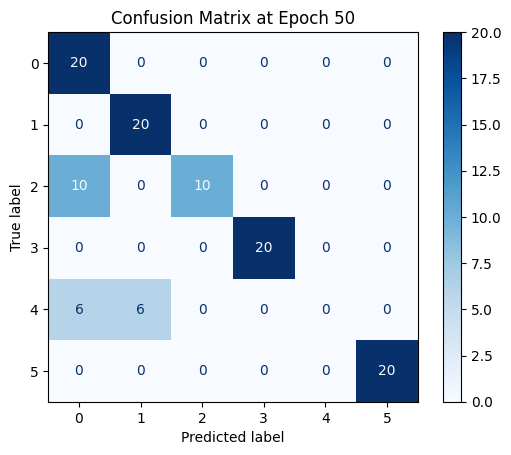

/home/uecai/.local/lib/python3.10/site-packages/matplotlib/axes/_base.py:2985: RuntimeWarning: overflow encountered in scalar add
  x0, x1 = inverse_trans.transform([x0t - delta, x1t + delta])


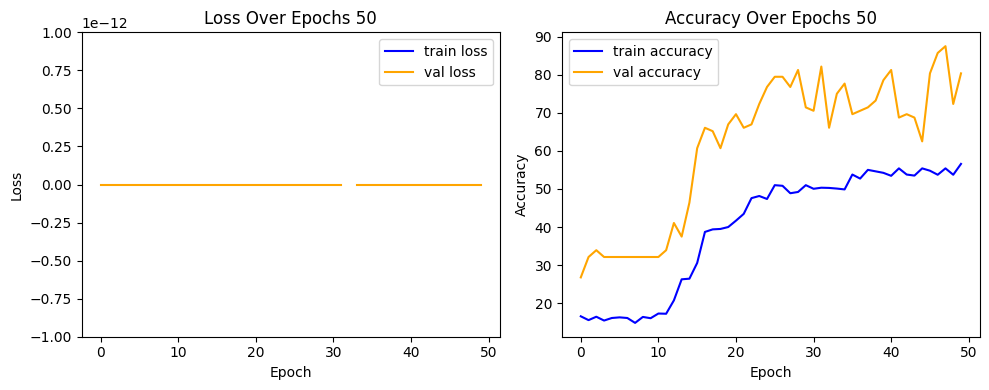

SP-[1] Epoch: 51/300 | Time: 0m04s (Train 0m04s  Val 0m00s) | Train: lr 0.1  Loss 1.0140  Acc 56.64% | HA 0.00@0 | Val: Loss 0.1630  Acc 69.64% | HA 87.50@48 | Sum 126.28 HA 87.50
SP-[1] Epoch: 52/300 | Time: 0m04s (Train 0m04s  Val 0m00s) | Train: lr 0.1  Loss 1.0186  Acc 55.86% | HA 0.00@0 | Val: Loss nan  Acc 74.11% | HA 87.50@48 | Sum 129.97 HA 87.50
SP-[1] Epoch: 53/300 | Time: 0m04s (Train 0m04s  Val 0m00s) | Train: lr 0.1  Loss 1.0143  Acc 57.25% | HA 0.00@0 | Val: Loss nan  Acc 67.86% | HA 87.50@48 | Sum 125.11 HA 87.50
SP-[1] Epoch: 54/300 | Time: 0m04s (Train 0m04s  Val 0m00s) | Train: lr 0.1  Loss 1.0168  Acc 56.14% | HA 0.00@0 | Val: Loss nan  Acc 63.39% | HA 87.50@48 | Sum 119.53 HA 87.50
SP-[1] Epoch: 55/300 | Time: 0m04s (Train 0m04s  Val 0m00s) | Train: lr 0.1  Loss 1.0011  Acc 61.33% | HA 0.00@0 | Val: Loss nan  Acc 69.64% | HA 87.50@48 | Sum 130.97 HA 87.50
SP-[1] Epoch: 56/300 | Time: 0m04s (Train 0m04s  Val 0m00s) | Train: lr 0.1  Loss 1.0040  Acc 59.93% | HA 0.00@0

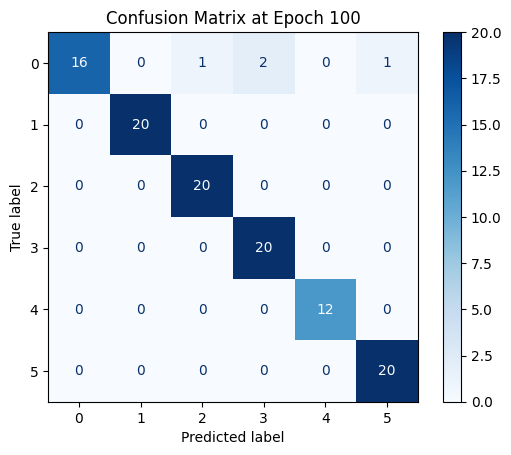

/home/uecai/.local/lib/python3.10/site-packages/matplotlib/axes/_base.py:2985: RuntimeWarning: overflow encountered in scalar add
  x0, x1 = inverse_trans.transform([x0t - delta, x1t + delta])


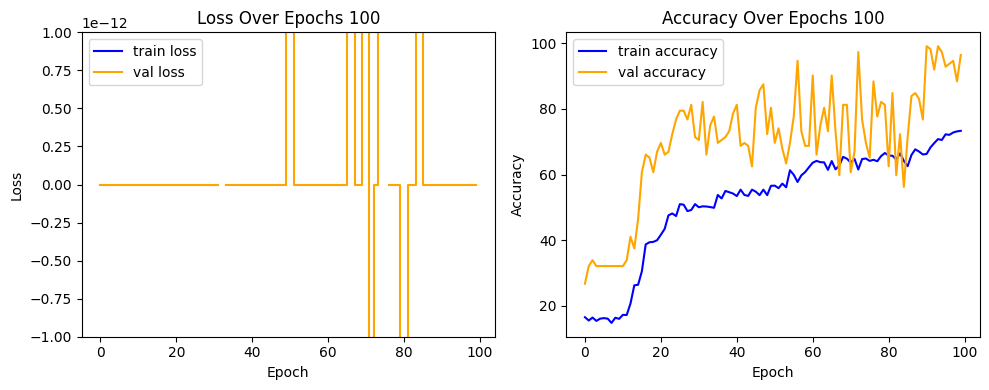

SP-[1] Epoch: 101/300 | Time: 0m04s (Train 0m04s  Val 0m00s) | Train: lr 0.010000000000000002  Loss 0.9164  Acc 72.21% | HA 0.00@0 | Val: Loss nan  Acc 92.86% | HA 99.11@94 | Sum 165.07 HA 99.11
SP-[1] Epoch: 102/300 | Time: 0m04s (Train 0m04s  Val 0m00s) | Train: lr 0.010000000000000002  Loss 0.9174  Acc 70.93% | HA 0.00@0 | Val: Loss nan  Acc 92.86% | HA 99.11@94 | Sum 163.78 HA 99.11
SP-[1] Epoch: 103/300 | Time: 0m04s (Train 0m04s  Val 0m00s) | Train: lr 0.010000000000000002  Loss 0.9150  Acc 73.33% | HA 0.00@0 | Val: Loss nan  Acc 91.96% | HA 99.11@94 | Sum 165.29 HA 99.11
SP-[1] Epoch: 104/300 | Time: 0m04s (Train 0m04s  Val 0m00s) | Train: lr 0.010000000000000002  Loss 0.9126  Acc 71.93% | HA 0.00@0 | Val: Loss nan  Acc 98.21% | HA 99.11@94 | Sum 170.15 HA 99.11
SP-[1] Epoch: 105/300 | Time: 0m04s (Train 0m04s  Val 0m00s) | Train: lr 0.010000000000000002  Loss 0.9104  Acc 72.54% | HA 0.00@0 | Val: Loss nan  Acc 96.43% | HA 99.11@94 | Sum 168.97 HA 99.11
SP-[1] Epoch: 106/300 | T

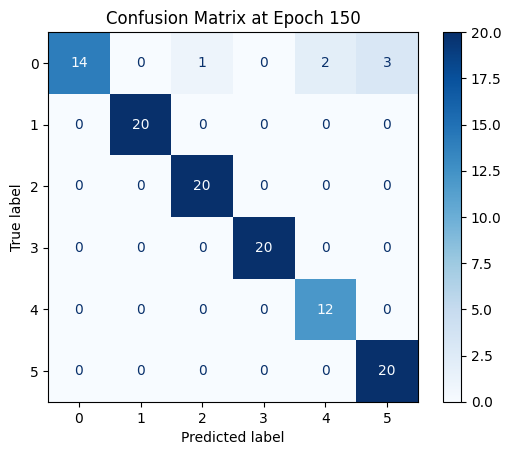

/home/uecai/.local/lib/python3.10/site-packages/matplotlib/axes/_base.py:2985: RuntimeWarning: overflow encountered in scalar add
  x0, x1 = inverse_trans.transform([x0t - delta, x1t + delta])


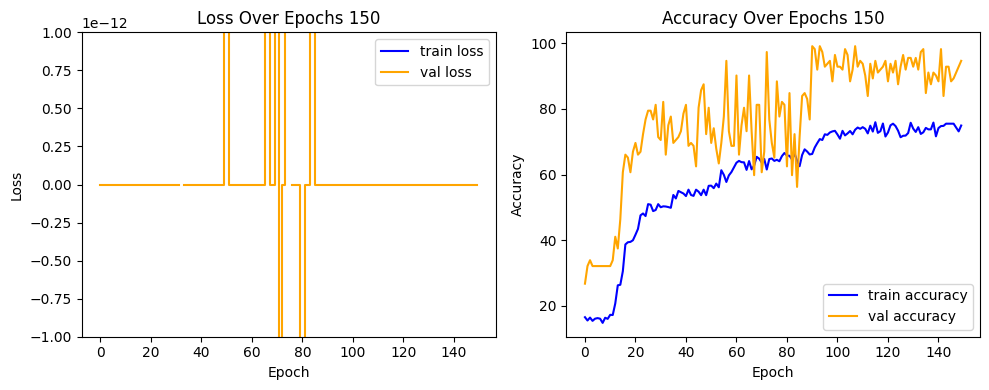

SP-[1] Epoch: 151/300 | Time: 0m04s (Train 0m04s  Val 0m00s) | Train: lr 0.0010000000000000002  Loss 0.8941  Acc 75.84% | HA 75.95@116 | Val: Loss nan  Acc 91.07% | HA 99.11@108 | Sum 166.91 HA 175.06
SP-[1] Epoch: 152/300 | Time: 0m04s (Train 0m04s  Val 0m00s) | Train: lr 0.0010000000000000002  Loss 0.8976  Acc 75.28% | HA 75.95@116 | Val: Loss nan  Acc 95.54% | HA 99.11@108 | Sum 170.81 HA 175.06
SP-[1] Epoch: 153/300 | Time: 0m04s (Train 0m04s  Val 0m00s) | Train: lr 0.0010000000000000002  Loss 0.8991  Acc 75.22% | HA 75.95@116 | Val: Loss nan  Acc 91.96% | HA 99.11@108 | Sum 167.19 HA 175.06
SP-[1] Epoch: 154/300 | Time: 0m04s (Train 0m04s  Val 0m00s) | Train: lr 0.0010000000000000002  Loss 0.8984  Acc 75.06% | HA 75.95@116 | Val: Loss nan  Acc 91.96% | HA 99.11@108 | Sum 167.02 HA 175.06
SP-[1] Epoch: 155/300 | Time: 0m04s (Train 0m04s  Val 0m00s) | Train: lr 0.0010000000000000002  Loss 0.8881  Acc 75.67% | HA 75.95@116 | Val: Loss nan  Acc 91.96% | HA 99.11@108 | Sum 167.63 HA 17

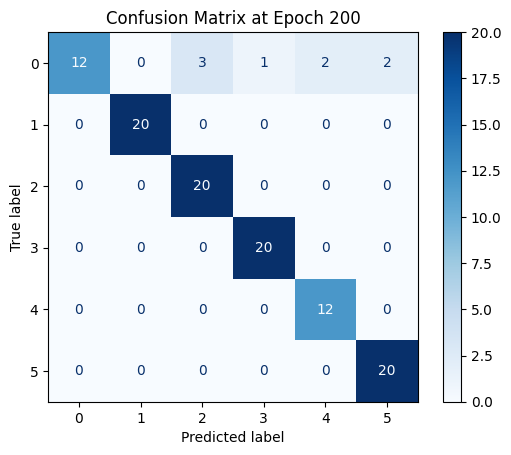

/home/uecai/.local/lib/python3.10/site-packages/matplotlib/axes/_base.py:2985: RuntimeWarning: overflow encountered in scalar add
  x0, x1 = inverse_trans.transform([x0t - delta, x1t + delta])


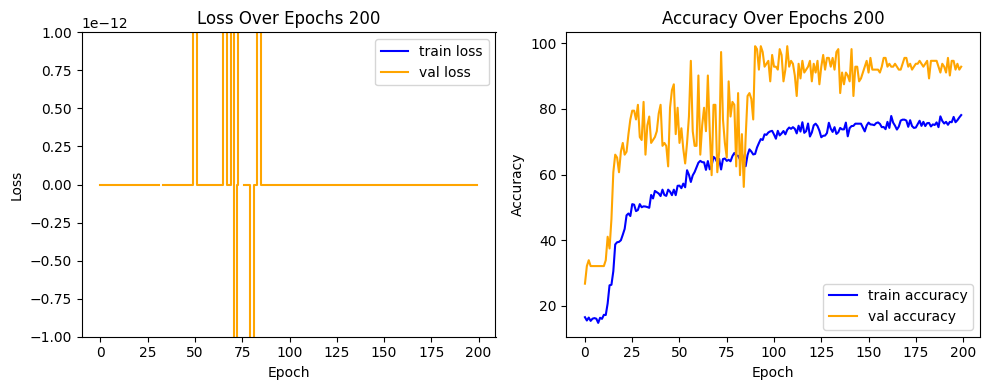

SP-[1] Epoch: 201/300 | Time: 0m04s (Train 0m04s  Val 0m00s) | Train: lr 0.0010000000000000002  Loss 0.8947  Acc 77.68% | HA 78.12@200 | Val: Loss nan  Acc 94.64% | HA 99.11@108 | Sum 172.32 HA 177.23
SP-[1] Epoch: 202/300 | Time: 0m04s (Train 0m04s  Val 0m00s) | Train: lr 0.0010000000000000002  Loss 0.8914  Acc 77.29% | HA 78.12@200 | Val: Loss nan  Acc 91.96% | HA 99.11@108 | Sum 169.25 HA 177.23
SP-[1] Epoch: 203/300 | Time: 0m04s (Train 0m04s  Val 0m00s) | Train: lr 0.0010000000000000002  Loss 0.8922  Acc 75.11% | HA 78.12@200 | Val: Loss nan  Acc 92.86% | HA 99.11@108 | Sum 167.97 HA 177.23
SP-[1] Epoch: 204/300 | Time: 0m04s (Train 0m04s  Val 0m00s) | Train: lr 0.0010000000000000002  Loss 0.8866  Acc 76.84% | HA 78.12@200 | Val: Loss nan  Acc 91.96% | HA 99.11@108 | Sum 168.81 HA 177.23
SP-[1] Epoch: 205/300 | Time: 0m04s (Train 0m04s  Val 0m00s) | Train: lr 0.0010000000000000002  Loss 0.8907  Acc 76.51% | HA 78.12@200 | Val: Loss nan  Acc 93.75% | HA 99.11@108 | Sum 170.26 HA 17

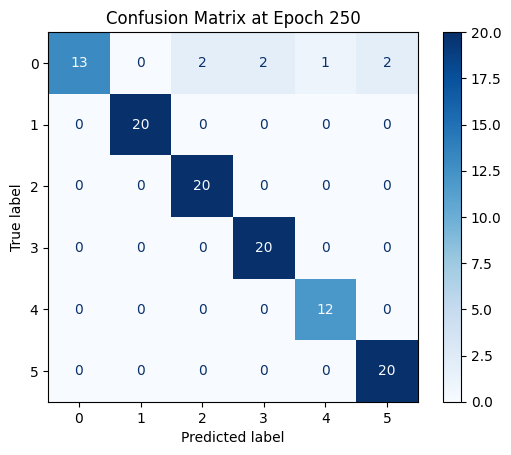

/home/uecai/.local/lib/python3.10/site-packages/matplotlib/axes/_base.py:2985: RuntimeWarning: overflow encountered in scalar add
  x0, x1 = inverse_trans.transform([x0t - delta, x1t + delta])


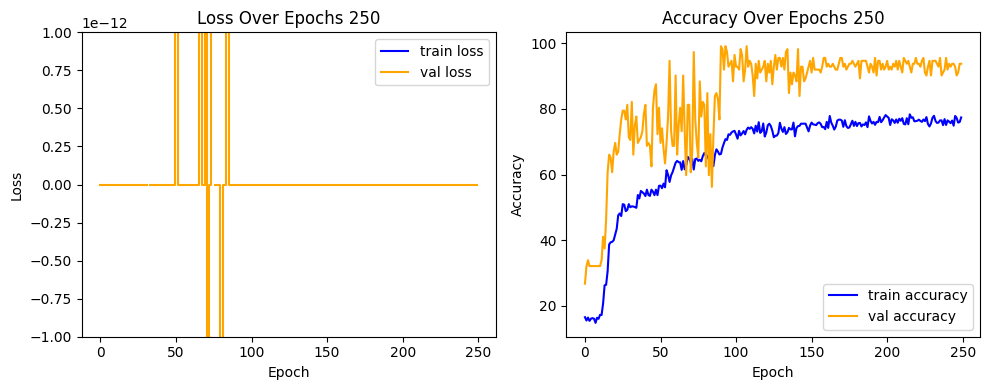

SP-[1] Epoch: 251/300 | Time: 0m04s (Train 0m04s  Val 0m00s) | Train: lr 0.0010000000000000002  Loss 0.8904  Acc 77.23% | HA 78.35@216 | Val: Loss nan  Acc 91.07% | HA 99.11@108 | Sum 168.30 HA 177.46
SP-[1] Epoch: 252/300 | Time: 0m04s (Train 0m04s  Val 0m00s) | Train: lr 0.0010000000000000002  Loss 0.8893  Acc 75.06% | HA 78.35@216 | Val: Loss nan  Acc 91.07% | HA 99.11@108 | Sum 166.13 HA 177.46
SP-[1] Epoch: 253/300 | Time: 0m04s (Train 0m04s  Val 0m00s) | Train: lr 0.0010000000000000002  Loss 0.8947  Acc 75.84% | HA 78.35@216 | Val: Loss nan  Acc 91.96% | HA 99.11@108 | Sum 167.80 HA 177.46
SP-[1] Epoch: 254/300 | Time: 0m04s (Train 0m04s  Val 0m00s) | Train: lr 0.0010000000000000002  Loss 0.8954  Acc 74.67% | HA 78.35@216 | Val: Loss nan  Acc 90.18% | HA 99.11@108 | Sum 164.84 HA 177.46
SP-[1] Epoch: 255/300 | Time: 0m04s (Train 0m04s  Val 0m00s) | Train: lr 0.0010000000000000002  Loss 0.9013  Acc 75.45% | HA 78.35@216 | Val: Loss nan  Acc 90.18% | HA 99.11@108 | Sum 165.63 HA 17

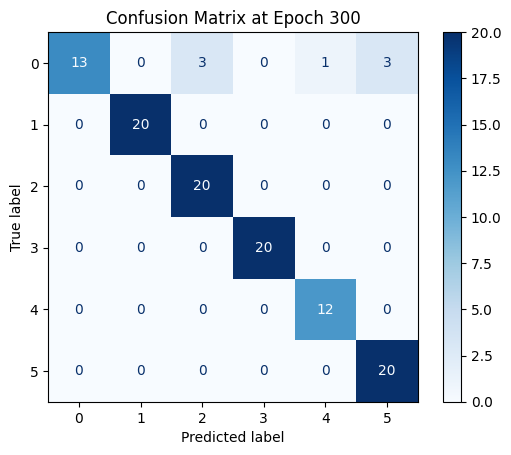

/home/uecai/.local/lib/python3.10/site-packages/matplotlib/axes/_base.py:2985: RuntimeWarning: overflow encountered in scalar add
  x0, x1 = inverse_trans.transform([x0t - delta, x1t + delta])


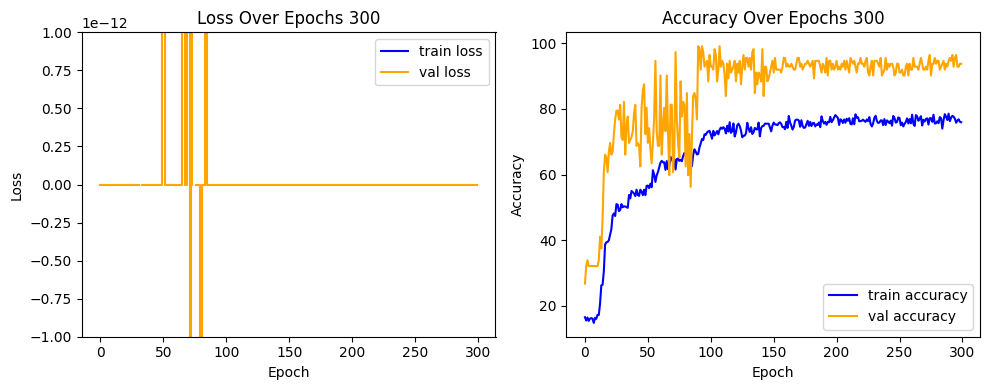

Execution finished in: 20m53s
350.89286477225164


In [12]:
step_1_model_path = main()
# main()


In [13]:
step_1_model_path

'/home/sail/sound_project/sound_ai_v2_more_cnn/sys/step_1_base_model/save_pt_model_s1/20241023_18/base4C_train_lr0.1_bs64_wd0.0005_20241023181539/6C_model_cnnhacc99.1071_valacc94.6429_hacctr78.5714_tracc78.5714_290th_sum_350.8929.pt'

## step 2

In [14]:
step_now = 'sys/step_2_pruning'

In [15]:
# step_1_model_path = '/home/sail/sound_project/sound_ai_v2.2.2/sys/step1_base_model/save_pt_model_s1/20241007_17/base4C_train_lr0.1_bs64_wd0.0005_20241007173709/6C_att_model_hacc100.0000_valacc99.1071_hacctr90.5093_tracc90.5093_298th_sum_380.1257.pt'

In [16]:
date_time = datetime.now().strftime("%Y%m%d_%H")  # %M
save_step_path = f'{project_PATH}/{step_now}'
save_pt_model_path = f'{save_step_path}/{date_time}'
try:
    os.mkdir(f'{project_PATH}/{step_now}')
    os.mkdir(save_step_path)
    print(f"Folder '{save_step_path}' created successfully.")
except FileExistsError:
    print(f"Folder '{save_step_path}' already exists.")
    
save_step_path = f'{project_PATH}/{step_now}/save_pt_model_s2'

try:
    os.mkdir(f'{project_PATH}/{step_now}')
    os.mkdir(save_step_path)
    print(f"Folder '{save_step_path}' created successfully.")
except FileExistsError:
    print(f"Folder '{save_step_path}' already exists.")
    
try:
    os.mkdir(save_pt_model_path)
    print(f"Folder '{save_pt_model_path}' created successfully.")
except FileExistsError:
    print(f"Folder '{save_pt_model_path}' already exists.")

Folder '/home/sail/sound_project/sound_ai_v2_more_cnn/sys/step_2_pruning' already exists.
Folder '/home/sail/sound_project/sound_ai_v2_more_cnn/sys/step_2_pruning/save_pt_model_s2' already exists.
Folder '/home/sail/sound_project/sound_ai_v2_more_cnn/sys/step_2_pruning/20241023_18' created successfully.


In [17]:
from sparsify import PruningTrainer


In [18]:
def main():
    global logObj;
    opt = getOpts()
    opt.trainer = None

    # opt.nEpochs = 300;
    # opt.least_save_epoch = 50;
    # opt.first_save_acc = 75.0;
    # opt.save_val_acc = 95.0;
    opt.save_train_acc = 90.0;

    opt.prune_ratio = pr_rate
    opt.base_model_path = step_1_model_path
    trainStartTime = getDateStr();
    save_dir = f"{save_pt_model_path}/pruning_4C_time_{trainStartTime}_prunratio{opt.prune_ratio*100}/"
    if not os.path.exists(save_dir):
        os.mkdir(save_dir)
    opt.save_dir = save_dir;
    opt.model_name = save_model_name+"_first_stage_prun_haacc_{:.4f}_valacc{:.4f}_tracc{:.4f}_epoch_{}.pt";
    print("Initializing PruneAndTrain Object.....")
    trainer = PruningTrainer(opt)#TLTrainer(opt)
    print("Start to pruning.....")
    logSaveDir = opt.save_dir+"/first_stage_pruning_logs/"
    opt.logSaveDir = logSaveDir
    ChkAndCreateSingleDir(logSaveDir);
    logName = "FirstPruningLog_{}.log".format(trainStartTime);
    opt.logObj = open(os.path.join(logSaveDir,logName),'w');
    trainer.PruneAndTrain();
    opt.logObj.flush();
    opt.logObj.close();
    return opt.best_save_name

***Use device:cuda:0
Initializing PruneAndTrain Object.....
random other
random other
!!! In PruningTrainer:: current used device:cuda:0
Start to pruning.....
'/home/sail/sound_project/sound_ai_v2_more_cnn/sys/step_2_pruning/20241023_18/pruning_4C_time_2024102318_prunratio90.0//first_stage_pruning_logs/' folder is created.
cuda:0
self.opt.ch_confing_10 32
self.ch_config [1, 16, 32, 1, 64, 32, 16, 16, 6]
+----------------------------------------------------------------------------+
+                           Pytorch Model Summary                            +
------------------------------------------------------------------------------
   Layer (type)       Input Shape      Output Shape    Param #      FLOPS #
       Conv2d-1     (1, 1, 16000)     (16, 1, 7996)        144    1,151,424
  BatchNorm2d-2     (16, 1, 7996)     (16, 1, 7996)         32            0
         ReLu-3     (16, 1, 7996)     (16, 1, 7996)          0      127,936
       Conv2d-4     (16, 1, 7996)     (32, 1, 3996) 

/home/sail/sound_project/sound_ai_v2_more_cnn/sys/sparsify.py:65: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load(self.opt.base_model_path, map_

SP-[1] Epoch: 1/300 | Time: 0m04s (Train 0m04s  Val 0m00s) | Train: lr 0.010000000000000002  Loss 1.0843  Acc 48.94% | HA 0.00@0 | Val: Loss nan  Acc 74.11% | HA 0.00@0 | Sum 123.05 HA 0.00
save model to /home/sail/sound_project/sound_ai_v2_more_cnn/sys/step_2_pruning/20241023_18/pruning_4C_time_2024102318_prunratio90.0/6C_model_cnn_first_stage_prun_haacc_91.0714_valacc91.0714_tracc58.6496_epoch_2.pt
SP-[1] Epoch: 2/300 | Time: 0m04s (Train 0m04s  Val 0m00s) | Train: lr 0.010000000000000002  Loss 1.0126  Acc 58.65% | HA 0.00@0 | Val: Loss nan  Acc 91.07% | HA 0.00@0 | Sum 149.72 HA 0.00
SP-[1] Epoch: 3/300 | Time: 0m04s (Train 0m04s  Val 0m00s) | Train: lr 0.010000000000000002  Loss 0.9852  Acc 64.90% | HA 0.00@0 | Val: Loss nan  Acc 87.50% | HA 0.00@0 | Sum 152.40 HA 0.00
SP-[1] Epoch: 4/300 | Time: 0m04s (Train 0m04s  Val 0m00s) | Train: lr 0.010000000000000002  Loss 0.9778  Acc 65.29% | HA 0.00@0 | Val: Loss nan  Acc 90.18% | HA 0.00@0 | Sum 155.47 HA 0.00
save model to /home/sail/s

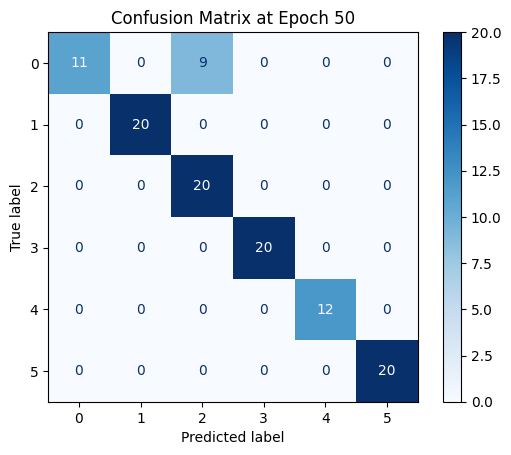

/home/uecai/.local/lib/python3.10/site-packages/matplotlib/axes/_base.py:2985: RuntimeWarning: overflow encountered in scalar add
  x0, x1 = inverse_trans.transform([x0t - delta, x1t + delta])


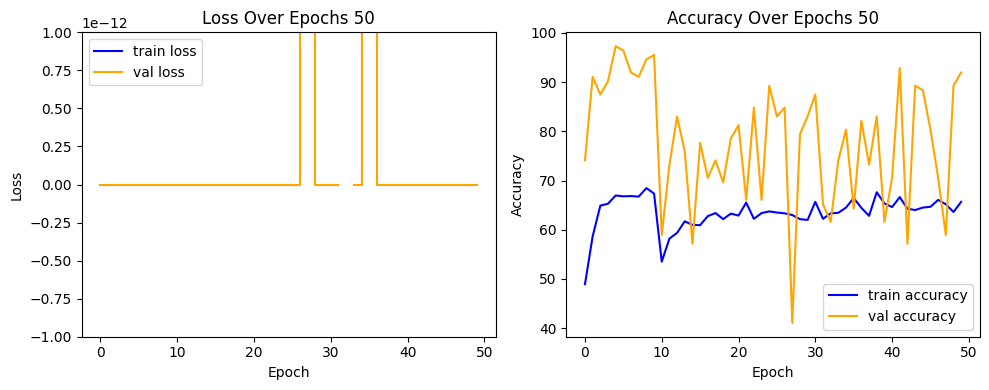

SP-[1] Epoch: 51/300 | Time: 0m04s (Train 0m04s  Val 0m00s) | Train: lr 0.1  Loss 0.9626  Acc 65.01% | HA 0.00@0 | Val: Loss 0.0495  Acc 77.68% | HA 0.00@0 | Sum 142.69 HA 0.00
SP-[1] Epoch: 52/300 | Time: 0m04s (Train 0m04s  Val 0m00s) | Train: lr 0.1  Loss 0.9653  Acc 65.12% | HA 0.00@0 | Val: Loss 1.3125  Acc 39.29% | HA 0.00@0 | Sum 104.41 HA 0.00
SP-[1] Epoch: 53/300 | Time: 0m04s (Train 0m04s  Val 0m00s) | Train: lr 0.1  Loss 0.9598  Acc 66.96% | HA 0.00@0 | Val: Loss nan  Acc 81.25% | HA 0.00@0 | Sum 148.21 HA 0.00
SP-[1] Epoch: 54/300 | Time: 0m04s (Train 0m04s  Val 0m00s) | Train: lr 0.1  Loss 0.9526  Acc 65.51% | HA 0.00@0 | Val: Loss nan  Acc 78.57% | HA 0.00@0 | Sum 144.08 HA 0.00
SP-[1] Epoch: 55/300 | Time: 0m04s (Train 0m04s  Val 0m00s) | Train: lr 0.1  Loss 0.9468  Acc 68.42% | HA 0.00@0 | Val: Loss nan  Acc 94.64% | HA 0.00@0 | Sum 163.06 HA 0.00
SP-[1] Epoch: 56/300 | Time: 0m04s (Train 0m04s  Val 0m00s) | Train: lr 0.1  Loss 0.9490  Acc 67.58% | HA 0.00@0 | Val: Loss

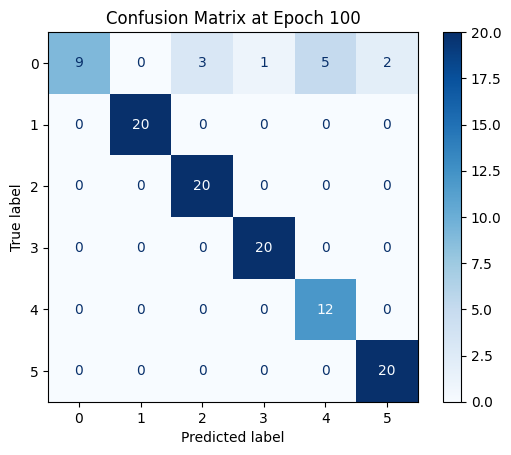

/home/uecai/.local/lib/python3.10/site-packages/matplotlib/axes/_base.py:2985: RuntimeWarning: overflow encountered in scalar add
  x0, x1 = inverse_trans.transform([x0t - delta, x1t + delta])


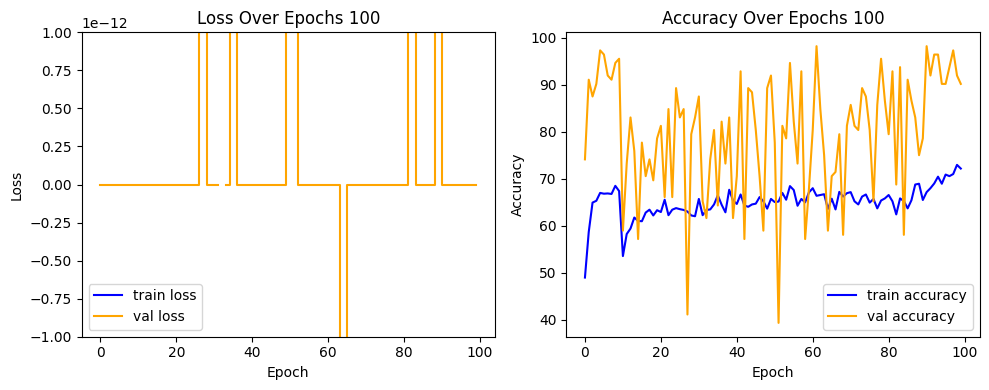

SP-[1] Epoch: 101/300 | Time: 0m04s (Train 0m04s  Val 0m00s) | Train: lr 0.010000000000000002  Loss 0.9253  Acc 70.87% | HA 0.00@0 | Val: Loss nan  Acc 92.86% | HA 0.00@0 | Sum 163.73 HA 0.00
SP-[1] Epoch: 102/300 | Time: 0m04s (Train 0m04s  Val 0m00s) | Train: lr 0.010000000000000002  Loss 0.9242  Acc 69.64% | HA 0.00@0 | Val: Loss nan  Acc 94.64% | HA 0.00@0 | Sum 164.29 HA 0.00
SP-[1] Epoch: 103/300 | Time: 0m04s (Train 0m04s  Val 0m00s) | Train: lr 0.010000000000000002  Loss 0.9208  Acc 73.05% | HA 0.00@0 | Val: Loss nan  Acc 88.39% | HA 0.00@0 | Sum 161.44 HA 0.00
SP-[1] Epoch: 104/300 | Time: 0m04s (Train 0m04s  Val 0m00s) | Train: lr 0.010000000000000002  Loss 0.9206  Acc 71.26% | HA 0.00@0 | Val: Loss nan  Acc 92.86% | HA 0.00@0 | Sum 164.12 HA 0.00
SP-[1] Epoch: 105/300 | Time: 0m04s (Train 0m04s  Val 0m00s) | Train: lr 0.010000000000000002  Loss 0.9199  Acc 70.48% | HA 0.00@0 | Val: Loss nan  Acc 92.86% | HA 0.00@0 | Sum 163.34 HA 0.00
SP-[1] Epoch: 106/300 | Time: 0m04s (Tra

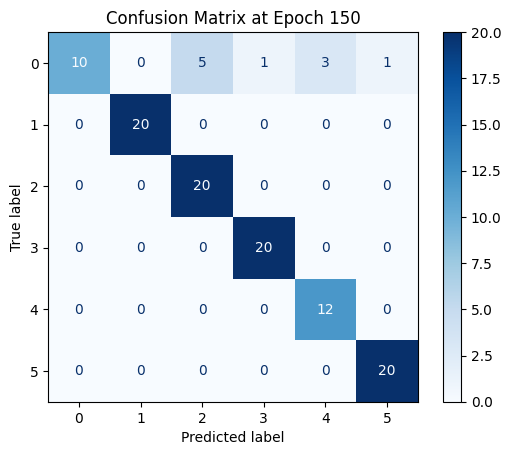

/home/uecai/.local/lib/python3.10/site-packages/matplotlib/axes/_base.py:2985: RuntimeWarning: overflow encountered in scalar add
  x0, x1 = inverse_trans.transform([x0t - delta, x1t + delta])


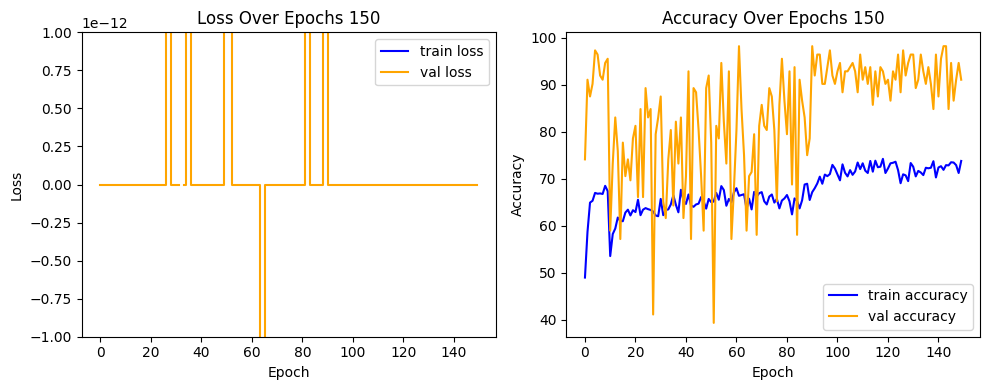

SP-[1] Epoch: 151/300 | Time: 0m04s (Train 0m04s  Val 0m00s) | Train: lr 0.0010000000000000002  Loss 0.9091  Acc 73.44% | HA 0.00@0 | Val: Loss nan  Acc 87.50% | HA 0.00@0 | Sum 160.94 HA 0.00
SP-[1] Epoch: 152/300 | Time: 0m04s (Train 0m04s  Val 0m00s) | Train: lr 0.0010000000000000002  Loss 0.9125  Acc 73.44% | HA 0.00@0 | Val: Loss nan  Acc 90.18% | HA 0.00@0 | Sum 163.62 HA 0.00
SP-[1] Epoch: 153/300 | Time: 0m04s (Train 0m04s  Val 0m00s) | Train: lr 0.0010000000000000002  Loss 0.9112  Acc 73.66% | HA 0.00@0 | Val: Loss nan  Acc 91.07% | HA 0.00@0 | Sum 164.73 HA 0.00
SP-[1] Epoch: 154/300 | Time: 0m04s (Train 0m04s  Val 0m00s) | Train: lr 0.0010000000000000002  Loss 0.9132  Acc 72.49% | HA 0.00@0 | Val: Loss nan  Acc 89.29% | HA 0.00@0 | Sum 161.77 HA 0.00
SP-[1] Epoch: 155/300 | Time: 0m04s (Train 0m04s  Val 0m00s) | Train: lr 0.0010000000000000002  Loss 0.8999  Acc 74.27% | HA 0.00@0 | Val: Loss nan  Acc 91.96% | HA 0.00@0 | Sum 166.24 HA 0.00
SP-[1] Epoch: 156/300 | Time: 0m04s

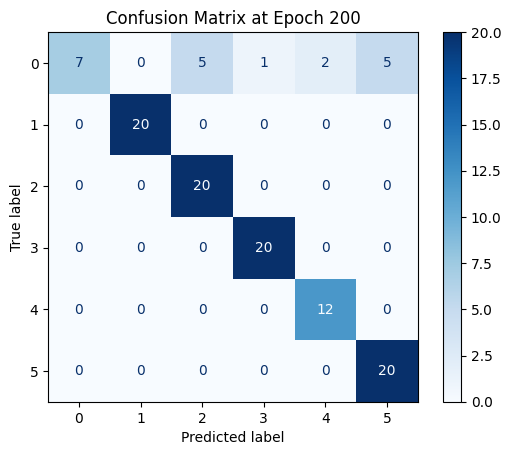

/home/uecai/.local/lib/python3.10/site-packages/matplotlib/axes/_base.py:2985: RuntimeWarning: overflow encountered in scalar add
  x0, x1 = inverse_trans.transform([x0t - delta, x1t + delta])


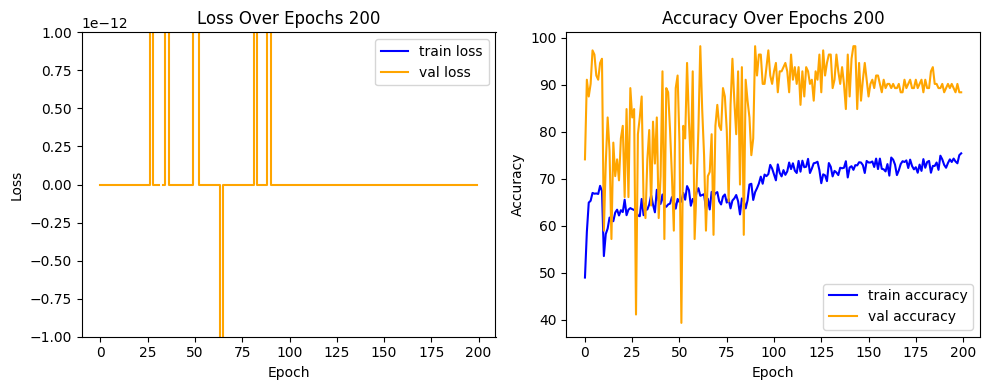

SP-[1] Epoch: 201/300 | Time: 0m04s (Train 0m04s  Val 0m00s) | Train: lr 0.0010000000000000002  Loss 0.9093  Acc 74.50% | HA 0.00@0 | Val: Loss nan  Acc 90.18% | HA 0.00@0 | Sum 164.68 HA 0.00
SP-[1] Epoch: 202/300 | Time: 0m04s (Train 0m04s  Val 0m00s) | Train: lr 0.0010000000000000002  Loss 0.9090  Acc 74.00% | HA 0.00@0 | Val: Loss nan  Acc 88.39% | HA 0.00@0 | Sum 162.39 HA 0.00
SP-[1] Epoch: 203/300 | Time: 0m04s (Train 0m04s  Val 0m00s) | Train: lr 0.0010000000000000002  Loss 0.9093  Acc 72.04% | HA 0.00@0 | Val: Loss nan  Acc 90.18% | HA 0.00@0 | Sum 162.22 HA 0.00
SP-[1] Epoch: 204/300 | Time: 0m04s (Train 0m04s  Val 0m00s) | Train: lr 0.0010000000000000002  Loss 0.9007  Acc 74.89% | HA 0.00@0 | Val: Loss nan  Acc 88.39% | HA 0.00@0 | Sum 163.28 HA 0.00
SP-[1] Epoch: 205/300 | Time: 0m04s (Train 0m04s  Val 0m00s) | Train: lr 0.0010000000000000002  Loss 0.9070  Acc 73.49% | HA 0.00@0 | Val: Loss nan  Acc 90.18% | HA 0.00@0 | Sum 163.67 HA 0.00
SP-[1] Epoch: 206/300 | Time: 0m04s

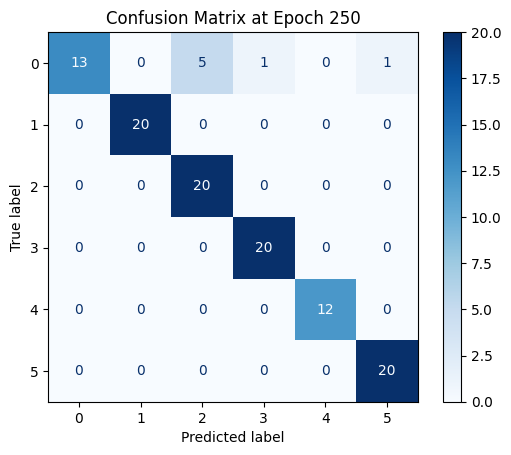

/home/uecai/.local/lib/python3.10/site-packages/matplotlib/axes/_base.py:2985: RuntimeWarning: overflow encountered in scalar add
  x0, x1 = inverse_trans.transform([x0t - delta, x1t + delta])


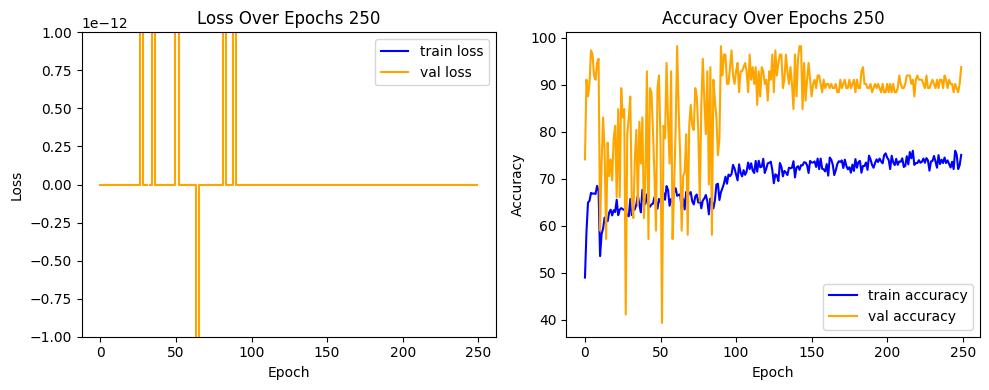

SP-[1] Epoch: 251/300 | Time: 0m04s (Train 0m04s  Val 0m00s) | Train: lr 0.0010000000000000002  Loss 0.9070  Acc 74.05% | HA 0.00@0 | Val: Loss nan  Acc 88.39% | HA 0.00@0 | Sum 162.44 HA 0.00
SP-[1] Epoch: 252/300 | Time: 0m04s (Train 0m04s  Val 0m00s) | Train: lr 0.0010000000000000002  Loss 0.9086  Acc 72.54% | HA 0.00@0 | Val: Loss nan  Acc 90.18% | HA 0.00@0 | Sum 162.72 HA 0.00
SP-[1] Epoch: 253/300 | Time: 0m04s (Train 0m04s  Val 0m00s) | Train: lr 0.0010000000000000002  Loss 0.9080  Acc 73.60% | HA 0.00@0 | Val: Loss nan  Acc 90.18% | HA 0.00@0 | Sum 163.78 HA 0.00
SP-[1] Epoch: 254/300 | Time: 0m04s (Train 0m04s  Val 0m00s) | Train: lr 0.0010000000000000002  Loss 0.9085  Acc 72.88% | HA 0.00@0 | Val: Loss nan  Acc 88.39% | HA 0.00@0 | Sum 161.27 HA 0.00
SP-[1] Epoch: 255/300 | Time: 0m04s (Train 0m04s  Val 0m00s) | Train: lr 0.0010000000000000002  Loss 0.9200  Acc 72.77% | HA 0.00@0 | Val: Loss nan  Acc 89.29% | HA 0.00@0 | Sum 162.05 HA 0.00
SP-[1] Epoch: 256/300 | Time: 0m04s

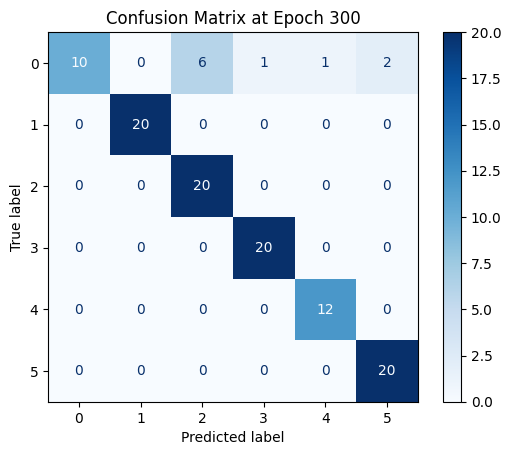

/home/uecai/.local/lib/python3.10/site-packages/matplotlib/axes/_base.py:2985: RuntimeWarning: overflow encountered in scalar add
  x0, x1 = inverse_trans.transform([x0t - delta, x1t + delta])


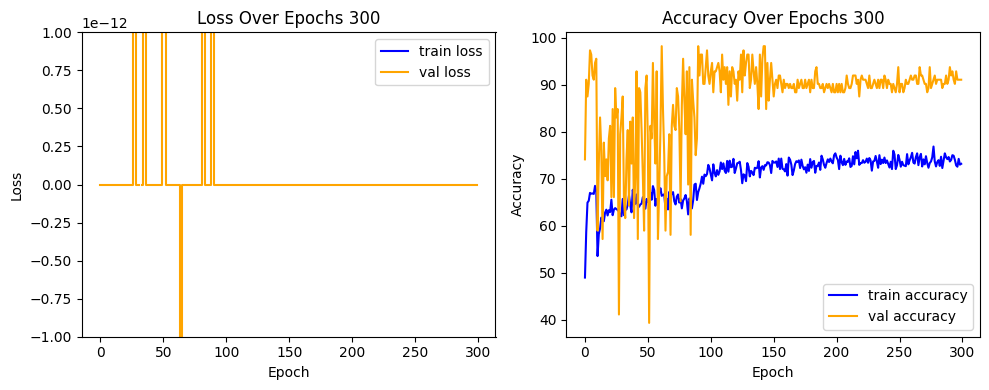

Execution finished in: 20m57s


In [19]:
step_2_model_path = main()


In [20]:
step_2_model_path

'/home/sail/sound_project/sound_ai_v2_more_cnn/sys/step_2_pruning/20241023_18/pruning_4C_time_2024102318_prunratio90.0/6C_model_cnn_first_stage_prun_haacc_98.2143_valacc91.0714_tracc76.8415_epoch_278.pt'

## step3

In [21]:
# step_2_model_path = '/home/sail/sound_project/sound_ai_v2_moreother/sys/step_2_pruning/20241021_15/pruning_4C_time_2024102115_prunratio90.0/6C_model_s_first_stage_prun_haacc_91.0714_valacc91.0714_tracc60.7292_epoch_52.pt'

In [22]:
step_now = 'sys/step_3_pruning'
date_time = datetime.now().strftime("%Y%m%d_%H")  # %M
save_step_path = f'{project_PATH}/{step_now}'
save_pt_model_path = f'{save_step_path}/{date_time}'
try:
    os.mkdir(f'{project_PATH}/{step_now}')
    os.mkdir(save_step_path)
    print(f"Folder '{save_step_path}' created successfully.")
except FileExistsError:
    print(f"Folder '{save_step_path}' already exists.")
save_step_path = f'{project_PATH}/{step_now}/save_pt_model_s3'

try:
    os.mkdir(f'{project_PATH}/{step_now}')
    os.mkdir(save_step_path)
    print(f"Folder '{save_step_path}' created successfully.")
except FileExistsError:
    print(f"Folder '{save_step_path}' already exists.")
    
try:
    os.mkdir(save_pt_model_path)
    print(f"Folder '{save_pt_model_path}' created successfully.")
except FileExistsError:
    print(f"Folder '{save_pt_model_path}' already exists.")

Folder '/home/sail/sound_project/sound_ai_v2_more_cnn/sys/step_3_pruning' already exists.
Folder '/home/sail/sound_project/sound_ai_v2_more_cnn/sys/step_3_pruning/save_pt_model_s3' already exists.
Folder '/home/sail/sound_project/sound_ai_v2_more_cnn/sys/step_3_pruning/20241023_18' created successfully.


In [23]:
from pruning import PruningTrainer


In [24]:
def main():
    opt = getOpts()
    
    
    opt.prune_ratio = pr_rate # 0.9
    opt.prune_all = True;

    opt.base_model_path = step_2_model_path

    save_dir = f"{save_pt_model_path}/uec_secondPrun_time_{getDateStr()}_prunratio{opt.prune_ratio*100}/"
    if not os.path.exists(save_dir):
        os.mkdir(save_dir)

    opt.save_dir = save_dir;
    model_name = save_model_name+"second_stage_prun_ratio{}_{}.pt".format(opt.prune_ratio, genDataTimeStr());
    opt.model_name = save_dir + model_name;
    opt.logSaveDir = opt.save_dir+"/second_stage_pruning_logs/"
    ChkAndCreateSingleDir(opt.logSaveDir)
    # valid_path = False;
    print("Initializing PruneAndTrain Object.....")
    trainer = PruningTrainer(opt=opt)
    print("Start to pruning.....")
    trainer.PruneAndTrain();
    return opt.model_name

***Use device:cuda:0
'/home/sail/sound_project/sound_ai_v2_more_cnn/sys/step_3_pruning/20241023_18/uec_secondPrun_time_2024102318_prunratio90.0//second_stage_pruning_logs/' folder is created.
Initializing PruneAndTrain Object.....
random other
random other
device is: cuda:0
Start to pruning.....
self.opt.ch_confing_10 32
self.ch_config [1, 16, 32, 1, 64, 32, 16, 16, 6]
 --- chonfig[1, 16, 32, 1, 64, 32, 16, 16, 6]
self.net att_Model(
  (sfeb): Sequential(
    (0): Conv2d(1, 16, kernel_size=(1, 9), stride=(1, 2), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(16, 32, kernel_size=(1, 5), stride=(1, 2), bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=(1, 40), stride=(1, 40), padding=0, dilation=1, ceil_mode=False)
  )
  (tfeb): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(

/home/sail/sound_project/sound_ai_v2_more_cnn/sys/pruning.py:56: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.net.load_state_dict(torch.load(trained_model, map_locatio

new_conv Conv2d(1, 63, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) new_bn BatchNorm2d(63, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Input: 0.061 MB, Params: 22,347 (0.085 MB), Total: 0.15 MB, FLOPs: 19,989,234
In val 
+----------------------------------------------------------------------------+
+                           Pytorch Model Summary                            +
------------------------------------------------------------------------------
   Layer (type)       Input Shape      Output Shape    Param #      FLOPS #
       Conv2d-1     (1, 1, 16000)     (16, 1, 7996)        144    1,151,424
  BatchNorm2d-2     (16, 1, 7996)     (16, 1, 7996)         32            0
         ReLu-3     (16, 1, 7996)     (16, 1, 7996)          0      127,936
       Conv2d-4     (16, 1, 7996)     (32, 1, 3996)      2,560   10,229,760
  BatchNorm2d-5     (32, 1, 3996)     (32, 1, 3996)         64            0
         ReLu-6     (32, 1, 3996)     (32, 1, 39

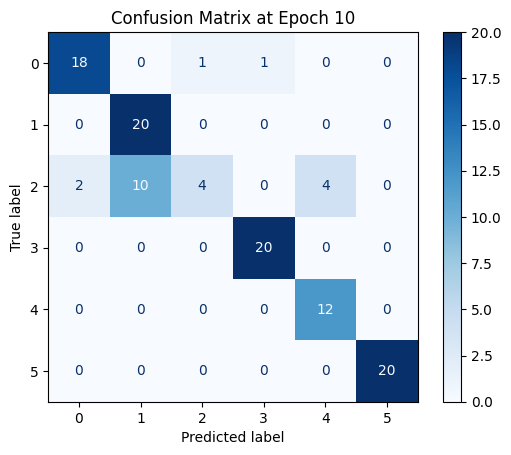

In val 
+----------------------------------------------------------------------------+
+                           Pytorch Model Summary                            +
------------------------------------------------------------------------------
   Layer (type)       Input Shape      Output Shape    Param #      FLOPS #
       Conv2d-1     (1, 1, 16000)     (16, 1, 7996)        144    1,151,424
  BatchNorm2d-2     (16, 1, 7996)     (16, 1, 7996)         32            0
         ReLu-3     (16, 1, 7996)     (16, 1, 7996)          0      127,936
       Conv2d-4     (16, 1, 7996)     (32, 1, 3996)      2,560   10,229,760
  BatchNorm2d-5     (32, 1, 3996)     (32, 1, 3996)         64            0
         ReLu-6     (32, 1, 3996)     (32, 1, 3996)          0      127,872
    MaxPool2d-7     (32, 1, 3996)       (32, 1, 99)          0      126,720
      Permute-8       (32, 1, 99)       (1, 32, 99)          0            0
       Conv2d-9       (1, 32, 99)      (59, 32, 99)        531    1,682

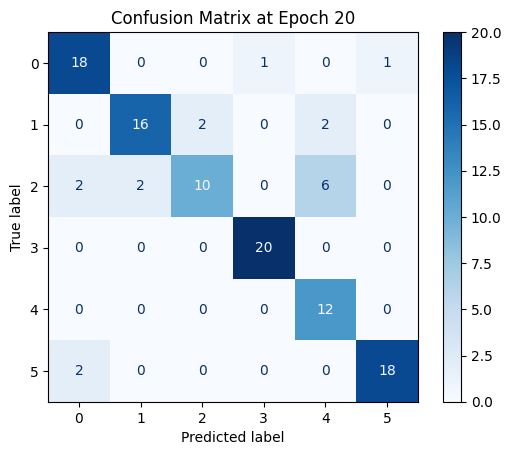

In val 
+----------------------------------------------------------------------------+
+                           Pytorch Model Summary                            +
------------------------------------------------------------------------------
   Layer (type)       Input Shape      Output Shape    Param #      FLOPS #
       Conv2d-1     (1, 1, 16000)     (14, 1, 7996)        126    1,007,496
  BatchNorm2d-2     (14, 1, 7996)     (14, 1, 7996)         28            0
         ReLu-3     (14, 1, 7996)     (14, 1, 7996)          0      111,944
       Conv2d-4     (14, 1, 7996)     (32, 1, 3996)      2,240    8,951,040
  BatchNorm2d-5     (32, 1, 3996)     (32, 1, 3996)         64            0
         ReLu-6     (32, 1, 3996)     (32, 1, 3996)          0      127,872
    MaxPool2d-7     (32, 1, 3996)       (32, 1, 99)          0      126,720
      Permute-8       (32, 1, 99)       (1, 32, 99)          0            0
       Conv2d-9       (1, 32, 99)      (54, 32, 99)        486    1,539

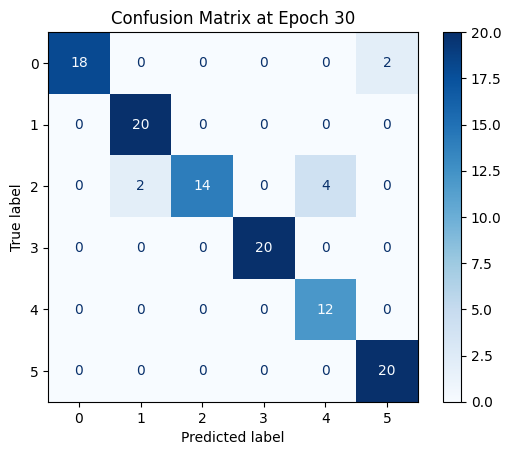

In val 
+----------------------------------------------------------------------------+
+                           Pytorch Model Summary                            +
------------------------------------------------------------------------------
   Layer (type)       Input Shape      Output Shape    Param #      FLOPS #
       Conv2d-1     (1, 1, 16000)     (12, 1, 7996)        108      863,568
  BatchNorm2d-2     (12, 1, 7996)     (12, 1, 7996)         24            0
         ReLu-3     (12, 1, 7996)     (12, 1, 7996)          0       95,952
       Conv2d-4     (12, 1, 7996)     (32, 1, 3996)      1,920    7,672,320
  BatchNorm2d-5     (32, 1, 3996)     (32, 1, 3996)         64            0
         ReLu-6     (32, 1, 3996)     (32, 1, 3996)          0      127,872
    MaxPool2d-7     (32, 1, 3996)       (32, 1, 99)          0      126,720
      Permute-8       (32, 1, 99)       (1, 32, 99)          0            0
       Conv2d-9       (1, 32, 99)      (49, 32, 99)        441    1,397

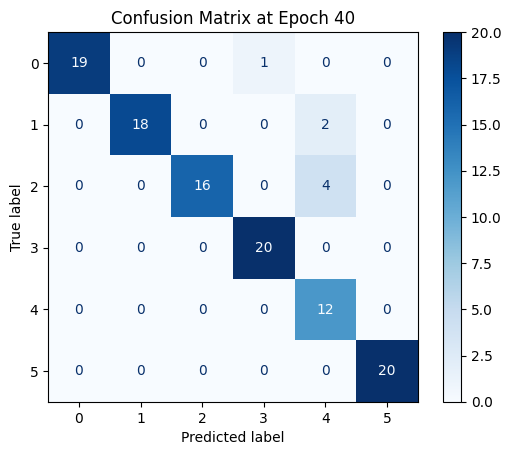

In val 
+----------------------------------------------------------------------------+
+                           Pytorch Model Summary                            +
------------------------------------------------------------------------------
   Layer (type)       Input Shape      Output Shape    Param #      FLOPS #
       Conv2d-1     (1, 1, 16000)     (11, 1, 7996)         99      791,604
  BatchNorm2d-2     (11, 1, 7996)     (11, 1, 7996)         22            0
         ReLu-3     (11, 1, 7996)     (11, 1, 7996)          0       87,956
       Conv2d-4     (11, 1, 7996)     (32, 1, 3996)      1,760    7,032,960
  BatchNorm2d-5     (32, 1, 3996)     (32, 1, 3996)         64            0
         ReLu-6     (32, 1, 3996)     (32, 1, 3996)          0      127,872
    MaxPool2d-7     (32, 1, 3996)       (32, 1, 99)          0      126,720
      Permute-8       (32, 1, 99)       (1, 32, 99)          0            0
       Conv2d-9       (1, 32, 99)      (42, 32, 99)        378    1,197

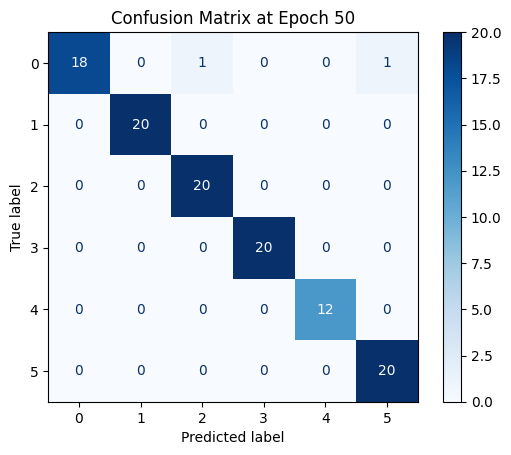

In val 
+----------------------------------------------------------------------------+
+                           Pytorch Model Summary                            +
------------------------------------------------------------------------------
   Layer (type)       Input Shape      Output Shape    Param #      FLOPS #
       Conv2d-1     (1, 1, 16000)      (7, 1, 7996)         63      503,748
  BatchNorm2d-2      (7, 1, 7996)      (7, 1, 7996)         14            0
         ReLu-3      (7, 1, 7996)      (7, 1, 7996)          0       55,972
       Conv2d-4      (7, 1, 7996)     (32, 1, 3996)      1,120    4,475,520
  BatchNorm2d-5     (32, 1, 3996)     (32, 1, 3996)         64            0
         ReLu-6     (32, 1, 3996)     (32, 1, 3996)          0      127,872
    MaxPool2d-7     (32, 1, 3996)       (32, 1, 99)          0      126,720
      Permute-8       (32, 1, 99)       (1, 32, 99)          0            0
       Conv2d-9       (1, 32, 99)      (37, 32, 99)        333    1,054

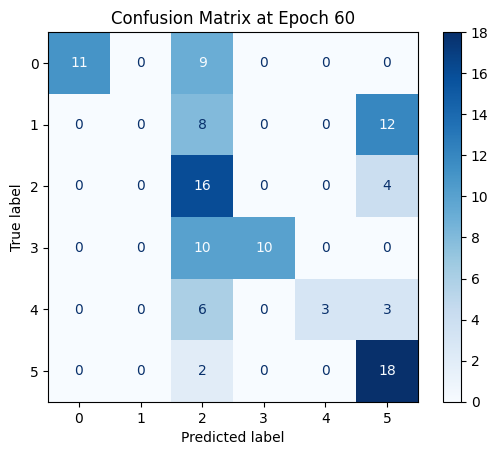

In val 
+----------------------------------------------------------------------------+
+                           Pytorch Model Summary                            +
------------------------------------------------------------------------------
   Layer (type)       Input Shape      Output Shape    Param #      FLOPS #
       Conv2d-1     (1, 1, 16000)      (2, 1, 7996)         18      143,928
  BatchNorm2d-2      (2, 1, 7996)      (2, 1, 7996)          4            0
         ReLu-3      (2, 1, 7996)      (2, 1, 7996)          0       15,992
       Conv2d-4      (2, 1, 7996)     (32, 1, 3996)        320    1,278,720
  BatchNorm2d-5     (32, 1, 3996)     (32, 1, 3996)         64            0
         ReLu-6     (32, 1, 3996)     (32, 1, 3996)          0      127,872
    MaxPool2d-7     (32, 1, 3996)       (32, 1, 99)          0      126,720
      Permute-8       (32, 1, 99)       (1, 32, 99)          0            0
       Conv2d-9       (1, 32, 99)      (32, 32, 99)        288      912

/home/uecai/.local/lib/python3.10/site-packages/torch/nn/init.py:453: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


config[1, 32, 32, 20, 15]
self.net att_Model(
  (output): Sequential(
    (0): Softmax(dim=1)
  )
  (sfeb): Sequential(
    (0): Conv2d(1, 1, kernel_size=(1, 9), stride=(1, 2), bias=False)
    (1): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(1, 32, kernel_size=(1, 5), stride=(1, 2), bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=(1, 40), stride=(1, 40), padding=0, dilation=1, ceil_mode=False)
  )
  (tfeb): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=(3, 3), stride=(3, 3), padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (5): BatchNorm2d(20, eps=1e-05, mo

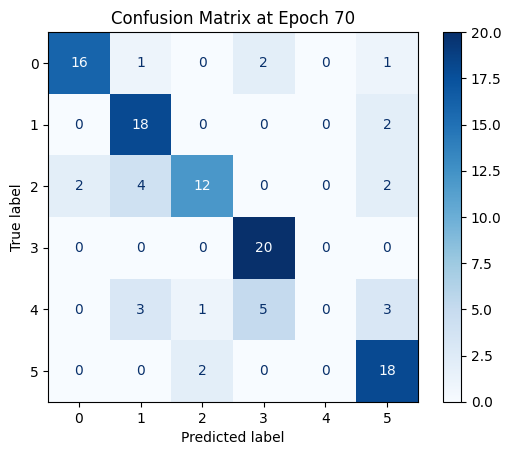

In val 
+----------------------------------------------------------------------------+
+                           Pytorch Model Summary                            +
------------------------------------------------------------------------------
   Layer (type)       Input Shape      Output Shape    Param #      FLOPS #
       Conv2d-1     (1, 1, 16000)      (1, 1, 7996)          9       71,964
  BatchNorm2d-2      (1, 1, 7996)      (1, 1, 7996)          2            0
         ReLu-3         (1, 7996)         (1, 7996)          0        7,996
       Conv2d-4      (1, 1, 7996)     (32, 1, 3996)        160      639,360
  BatchNorm2d-5     (32, 1, 3996)     (32, 1, 3996)         64            0
         ReLu-6     (32, 1, 3996)     (32, 1, 3996)          0      127,872
    MaxPool2d-7     (32, 1, 3996)       (32, 1, 99)          0      126,720
      Permute-8       (32, 1, 99)       (1, 32, 99)          0            0
       Conv2d-9       (1, 32, 99)      (30, 32, 99)        270      855

/home/uecai/.local/lib/python3.10/site-packages/torch/nn/init.py:453: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


config[1, 32, 29, 19, 15]
self.net att_Model(
  (output): Sequential(
    (0): Softmax(dim=1)
  )
  (sfeb): Sequential(
    (0): Conv2d(1, 1, kernel_size=(1, 9), stride=(1, 2), bias=False)
    (1): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(1, 32, kernel_size=(1, 5), stride=(1, 2), bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=(1, 40), stride=(1, 40), padding=0, dilation=1, ceil_mode=False)
  )
  (tfeb): Sequential(
    (0): Conv2d(1, 29, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(29, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=(3, 3), stride=(3, 3), padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(29, 19, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (5): BatchNorm2d(19, eps=1e-05, mo

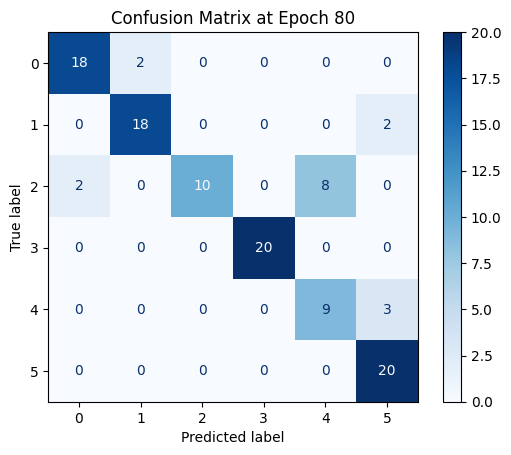

In val 
+----------------------------------------------------------------------------+
+                           Pytorch Model Summary                            +
------------------------------------------------------------------------------
   Layer (type)       Input Shape      Output Shape    Param #      FLOPS #
       Conv2d-1     (1, 1, 16000)      (1, 1, 7996)          9       71,964
  BatchNorm2d-2      (1, 1, 7996)      (1, 1, 7996)          2            0
         ReLu-3         (1, 7996)         (1, 7996)          0        7,996
       Conv2d-4      (1, 1, 7996)     (32, 1, 3996)        160      639,360
  BatchNorm2d-5     (32, 1, 3996)     (32, 1, 3996)         64            0
         ReLu-6     (32, 1, 3996)     (32, 1, 3996)          0      127,872
    MaxPool2d-7     (32, 1, 3996)       (32, 1, 99)          0      126,720
      Permute-8       (32, 1, 99)       (1, 32, 99)          0            0
       Conv2d-9       (1, 32, 99)      (29, 32, 99)        261      826

/home/uecai/.local/lib/python3.10/site-packages/torch/nn/init.py:453: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


config[1, 32, 29, 19, 15]
self.net att_Model(
  (output): Sequential(
    (0): Softmax(dim=1)
  )
  (sfeb): Sequential(
    (0): Conv2d(1, 1, kernel_size=(1, 9), stride=(1, 2), bias=False)
    (1): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(1, 32, kernel_size=(1, 5), stride=(1, 2), bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=(1, 40), stride=(1, 40), padding=0, dilation=1, ceil_mode=False)
  )
  (tfeb): Sequential(
    (0): Conv2d(1, 29, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(29, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=(3, 3), stride=(3, 3), padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(29, 19, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (5): BatchNorm2d(19, eps=1e-05, mo

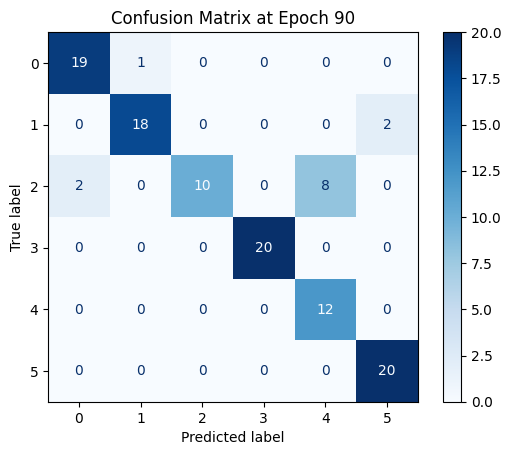

In val 
+----------------------------------------------------------------------------+
+                           Pytorch Model Summary                            +
------------------------------------------------------------------------------
   Layer (type)       Input Shape      Output Shape    Param #      FLOPS #
       Conv2d-1     (1, 1, 16000)      (1, 1, 7996)          9       71,964
  BatchNorm2d-2      (1, 1, 7996)      (1, 1, 7996)          2            0
         ReLu-3         (1, 7996)         (1, 7996)          0        7,996
       Conv2d-4      (1, 1, 7996)     (32, 1, 3996)        160      639,360
  BatchNorm2d-5     (32, 1, 3996)     (32, 1, 3996)         64            0
         ReLu-6     (32, 1, 3996)     (32, 1, 3996)          0      127,872
    MaxPool2d-7     (32, 1, 3996)       (32, 1, 99)          0      126,720
      Permute-8       (32, 1, 99)       (1, 32, 99)          0            0
       Conv2d-9       (1, 32, 99)      (29, 32, 99)        261      826

/home/uecai/.local/lib/python3.10/site-packages/torch/nn/init.py:453: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


config[1, 32, 29, 19, 15]
self.net att_Model(
  (output): Sequential(
    (0): Softmax(dim=1)
  )
  (sfeb): Sequential(
    (0): Conv2d(1, 1, kernel_size=(1, 9), stride=(1, 2), bias=False)
    (1): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(1, 32, kernel_size=(1, 5), stride=(1, 2), bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=(1, 40), stride=(1, 40), padding=0, dilation=1, ceil_mode=False)
  )
  (tfeb): Sequential(
    (0): Conv2d(1, 29, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(29, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=(3, 3), stride=(3, 3), padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(29, 19, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (5): BatchNorm2d(19, eps=1e-05, mo

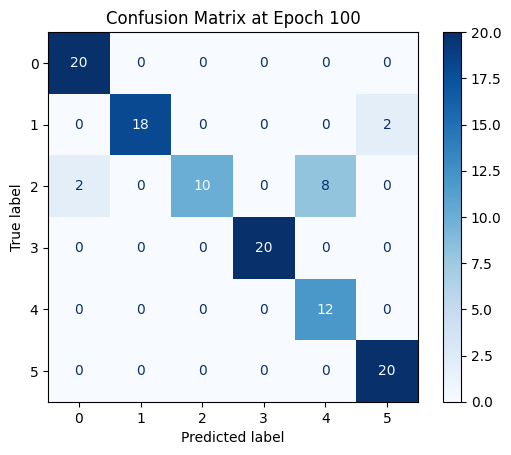

In val 
+----------------------------------------------------------------------------+
+                           Pytorch Model Summary                            +
------------------------------------------------------------------------------
   Layer (type)       Input Shape      Output Shape    Param #      FLOPS #
       Conv2d-1     (1, 1, 16000)      (1, 1, 7996)          9       71,964
  BatchNorm2d-2      (1, 1, 7996)      (1, 1, 7996)          2            0
         ReLu-3         (1, 7996)         (1, 7996)          0        7,996
       Conv2d-4      (1, 1, 7996)     (32, 1, 3996)        160      639,360
  BatchNorm2d-5     (32, 1, 3996)     (32, 1, 3996)         64            0
         ReLu-6     (32, 1, 3996)     (32, 1, 3996)          0      127,872
    MaxPool2d-7     (32, 1, 3996)       (32, 1, 99)          0      126,720
      Permute-8       (32, 1, 99)       (1, 32, 99)          0            0
       Conv2d-9       (1, 32, 99)      (29, 32, 99)        261      826

/home/uecai/.local/lib/python3.10/site-packages/torch/nn/init.py:453: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


config[1, 32, 29, 19, 15]
self.net att_Model(
  (output): Sequential(
    (0): Softmax(dim=1)
  )
  (sfeb): Sequential(
    (0): Conv2d(1, 1, kernel_size=(1, 9), stride=(1, 2), bias=False)
    (1): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(1, 32, kernel_size=(1, 5), stride=(1, 2), bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=(1, 40), stride=(1, 40), padding=0, dilation=1, ceil_mode=False)
  )
  (tfeb): Sequential(
    (0): Conv2d(1, 29, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(29, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=(3, 3), stride=(3, 3), padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(29, 19, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (5): BatchNorm2d(19, eps=1e-05, mo

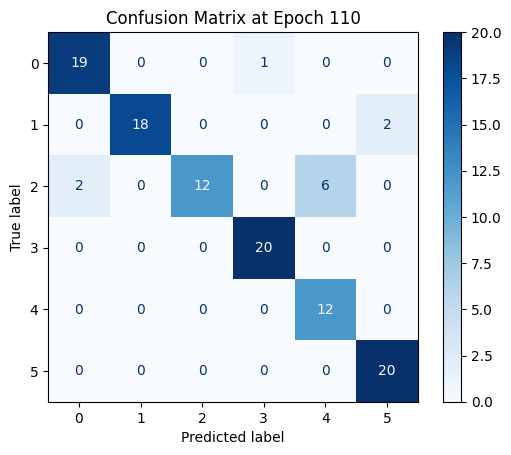

In val 
+----------------------------------------------------------------------------+
+                           Pytorch Model Summary                            +
------------------------------------------------------------------------------
   Layer (type)       Input Shape      Output Shape    Param #      FLOPS #
       Conv2d-1     (1, 1, 16000)      (1, 1, 7996)          9       71,964
  BatchNorm2d-2      (1, 1, 7996)      (1, 1, 7996)          2            0
         ReLu-3         (1, 7996)         (1, 7996)          0        7,996
       Conv2d-4      (1, 1, 7996)     (32, 1, 3996)        160      639,360
  BatchNorm2d-5     (32, 1, 3996)     (32, 1, 3996)         64            0
         ReLu-6     (32, 1, 3996)     (32, 1, 3996)          0      127,872
    MaxPool2d-7     (32, 1, 3996)       (32, 1, 99)          0      126,720
      Permute-8       (32, 1, 99)       (1, 32, 99)          0            0
       Conv2d-9       (1, 32, 99)      (29, 32, 99)        261      826

/home/uecai/.local/lib/python3.10/site-packages/torch/nn/init.py:453: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


config[1, 32, 29, 19, 15]
self.net att_Model(
  (output): Sequential(
    (0): Softmax(dim=1)
  )
  (sfeb): Sequential(
    (0): Conv2d(1, 1, kernel_size=(1, 9), stride=(1, 2), bias=False)
    (1): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(1, 32, kernel_size=(1, 5), stride=(1, 2), bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=(1, 40), stride=(1, 40), padding=0, dilation=1, ceil_mode=False)
  )
  (tfeb): Sequential(
    (0): Conv2d(1, 29, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(29, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=(3, 3), stride=(3, 3), padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(29, 19, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (5): BatchNorm2d(19, eps=1e-05, mo

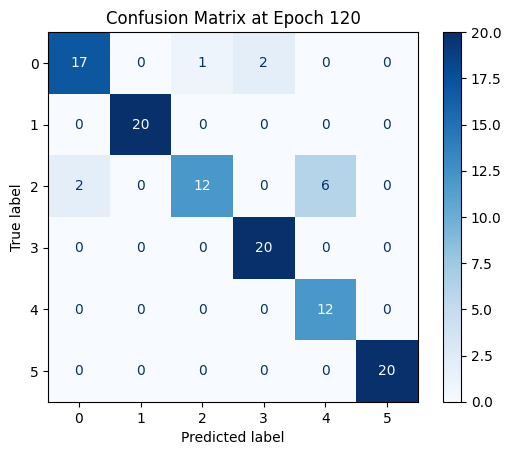

In val 
+----------------------------------------------------------------------------+
+                           Pytorch Model Summary                            +
------------------------------------------------------------------------------
   Layer (type)       Input Shape      Output Shape    Param #      FLOPS #
       Conv2d-1     (1, 1, 16000)      (1, 1, 7996)          9       71,964
  BatchNorm2d-2      (1, 1, 7996)      (1, 1, 7996)          2            0
         ReLu-3         (1, 7996)         (1, 7996)          0        7,996
       Conv2d-4      (1, 1, 7996)     (32, 1, 3996)        160      639,360
  BatchNorm2d-5     (32, 1, 3996)     (32, 1, 3996)         64            0
         ReLu-6     (32, 1, 3996)     (32, 1, 3996)          0      127,872
    MaxPool2d-7     (32, 1, 3996)       (32, 1, 99)          0      126,720
      Permute-8       (32, 1, 99)       (1, 32, 99)          0            0
       Conv2d-9       (1, 32, 99)      (29, 32, 99)        261      826

/home/uecai/.local/lib/python3.10/site-packages/torch/nn/init.py:453: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


config[1, 32, 29, 19, 15]
self.net att_Model(
  (output): Sequential(
    (0): Softmax(dim=1)
  )
  (sfeb): Sequential(
    (0): Conv2d(1, 1, kernel_size=(1, 9), stride=(1, 2), bias=False)
    (1): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(1, 32, kernel_size=(1, 5), stride=(1, 2), bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=(1, 40), stride=(1, 40), padding=0, dilation=1, ceil_mode=False)
  )
  (tfeb): Sequential(
    (0): Conv2d(1, 29, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(29, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=(3, 3), stride=(3, 3), padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(29, 19, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (5): BatchNorm2d(19, eps=1e-05, mo

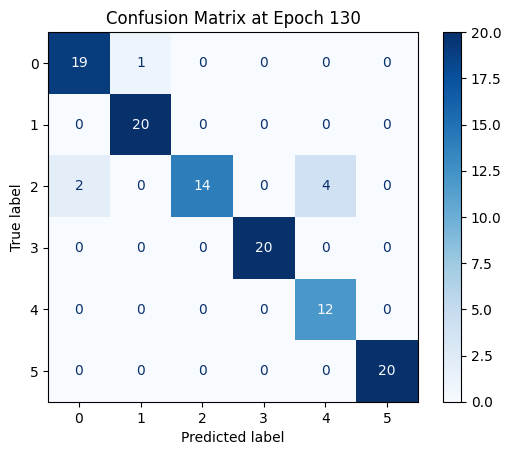

In val 
+----------------------------------------------------------------------------+
+                           Pytorch Model Summary                            +
------------------------------------------------------------------------------
   Layer (type)       Input Shape      Output Shape    Param #      FLOPS #
       Conv2d-1     (1, 1, 16000)      (1, 1, 7996)          9       71,964
  BatchNorm2d-2      (1, 1, 7996)      (1, 1, 7996)          2            0
         ReLu-3         (1, 7996)         (1, 7996)          0        7,996
       Conv2d-4      (1, 1, 7996)     (32, 1, 3996)        160      639,360
  BatchNorm2d-5     (32, 1, 3996)     (32, 1, 3996)         64            0
         ReLu-6     (32, 1, 3996)     (32, 1, 3996)          0      127,872
    MaxPool2d-7     (32, 1, 3996)       (32, 1, 99)          0      126,720
      Permute-8       (32, 1, 99)       (1, 32, 99)          0            0
       Conv2d-9       (1, 32, 99)      (29, 32, 99)        261      826

/home/uecai/.local/lib/python3.10/site-packages/torch/nn/init.py:453: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


config[1, 32, 29, 19, 15]
self.net att_Model(
  (output): Sequential(
    (0): Softmax(dim=1)
  )
  (sfeb): Sequential(
    (0): Conv2d(1, 1, kernel_size=(1, 9), stride=(1, 2), bias=False)
    (1): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(1, 32, kernel_size=(1, 5), stride=(1, 2), bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=(1, 40), stride=(1, 40), padding=0, dilation=1, ceil_mode=False)
  )
  (tfeb): Sequential(
    (0): Conv2d(1, 29, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(29, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=(3, 3), stride=(3, 3), padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(29, 19, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (5): BatchNorm2d(19, eps=1e-05, mo

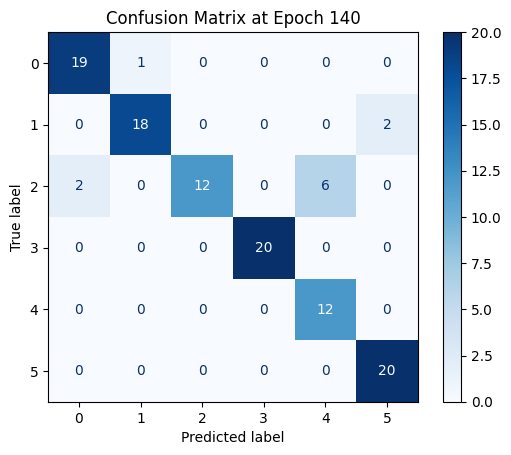

In val 
+----------------------------------------------------------------------------+
+                           Pytorch Model Summary                            +
------------------------------------------------------------------------------
   Layer (type)       Input Shape      Output Shape    Param #      FLOPS #
       Conv2d-1     (1, 1, 16000)      (1, 1, 7996)          9       71,964
  BatchNorm2d-2      (1, 1, 7996)      (1, 1, 7996)          2            0
         ReLu-3         (1, 7996)         (1, 7996)          0        7,996
       Conv2d-4      (1, 1, 7996)     (32, 1, 3996)        160      639,360
  BatchNorm2d-5     (32, 1, 3996)     (32, 1, 3996)         64            0
         ReLu-6     (32, 1, 3996)     (32, 1, 3996)          0      127,872
    MaxPool2d-7     (32, 1, 3996)       (32, 1, 99)          0      126,720
      Permute-8       (32, 1, 99)       (1, 32, 99)          0            0
       Conv2d-9       (1, 32, 99)      (28, 32, 99)        252      798

/home/uecai/.local/lib/python3.10/site-packages/torch/nn/init.py:453: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


config[1, 32, 28, 19, 15]
self.net att_Model(
  (output): Sequential(
    (0): Softmax(dim=1)
  )
  (sfeb): Sequential(
    (0): Conv2d(1, 1, kernel_size=(1, 9), stride=(1, 2), bias=False)
    (1): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(1, 32, kernel_size=(1, 5), stride=(1, 2), bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=(1, 40), stride=(1, 40), padding=0, dilation=1, ceil_mode=False)
  )
  (tfeb): Sequential(
    (0): Conv2d(1, 28, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(28, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=(3, 3), stride=(3, 3), padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(28, 19, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (5): BatchNorm2d(19, eps=1e-05, mo

In [25]:
step_3_model_path = main()

In [26]:
step_3_model_path 

'/home/sail/sound_project/sound_ai_v2_more_cnn/sys/step_3_pruning/20241023_18/uec_secondPrun_time_2024102318_prunratio90.0/6C_model_cnnsecond_stage_prun_ratio0.9_20241023185734.pt'

## step4

In [27]:
# step_3_model_path = '/home/sail/sound_project/sound_ai_v2_more_cnn/sys/step_3_pruning/20241023_15/uec_secondPrun_time_2024102315_prunratio90.0/6C_model_cnnsecond_stage_prun_ratio0.9_20241023151032.pt'

In [28]:
step_now = 'sys/step_4_retrain'
date_time = datetime.now().strftime("%Y%m%d_%H")  # %M
save_step_path = f'{project_PATH}/{step_now}'
save_pt_model_path = f'{save_step_path}/{date_time}'

try:
    os.mkdir(f'{project_PATH}/{step_now}')
    os.mkdir(save_step_path)
    print(f"Folder '{save_step_path}' created successfully.")
except FileExistsError:
    print(f"Folder '{save_step_path}' already exists.")
    
save_step_path = f'{project_PATH}/{step_now}/save_pt_model_s4'
try:
    os.mkdir(f'{project_PATH}/{step_now}')
    os.mkdir(save_step_path)
    print(f"Folder '{save_step_path}' created successfully.")
except FileExistsError:
    print(f"Folder '{save_step_path}' already exists.")

try:
    os.mkdir(save_pt_model_path)
    print(f"Folder '{save_pt_model_path}' created successfully.")
except FileExistsError:
    print(f"Folder '{save_pt_model_path}' already exists.")

Folder '/home/sail/sound_project/sound_ai_v2_more_cnn/sys/step_4_retrain' already exists.
Folder '/home/sail/sound_project/sound_ai_v2_more_cnn/sys/step_4_retrain/save_pt_model_s4' already exists.
Folder '/home/sail/sound_project/sound_ai_v2_more_cnn/sys/step_4_retrain/20241023_19' created successfully.


In [29]:
from retrain import ReTrainer

In [30]:
def main():

    opt = getOpts();

    # opt.lr = 0.05; # 0.1
    # opt.nEpochs = 500; # 1600
    # opt.schedule = [0.1, 0.3, 0.5, 0.9];
    # opt.schedule = [0.001, 0.003, 0.005, 0.01];
    # opt.warmup = 10;
    
    # opt.least_save_epoch = 10;
    opt.first_save_acc = 70.0;
    opt.save_val_acc = 95.0;
    opt.save_train_acc = 85.0;

    opt.pruningRatio = pr_rate
    
    save_dir = "{}/retrain_4C_after_2nd_pruning_prunratio{}_{}/".format(save_pt_model_path,opt.pruningRatio,getDateStr());
    if not os.path.exists(save_dir):
        os.mkdir(save_dir)
    opt.logSaveDir = save_dir
    print(f"save dir is: {save_dir}");
    opt.second_pruned_model = step_3_model_path

    opt.saveDir = save_dir;
    # opt.device="mps";
    if torch.cuda.is_available():
        opt.device="cuda:0"; #for nVidia gpu
    else:
        opt.device="cpu"
    print(f"***Use device:{opt.device}");
    # opt.device = torch.device("cuda:0" if  else "cpu");

    opt.model_name = save_model_name+"retrained_ratio{:.4f}_vaacc{:.4f}_tracc_{:.4f}@{}epoch.pt"
    
    #Starting retraining process
    trainer = ReTrainer(opt=opt);
    trainer.Train();
    return opt.best_save_name

***Use device:cuda:0
save dir is: /home/sail/sound_project/sound_ai_v2_more_cnn/sys/step_4_retrain/20241023_19/retrain_4C_after_2nd_pruning_prunratio0.9_2024102319/
***Use device:cuda:0
random other
random other
device is: cuda:0
config is [1, 32, 28, 19, 14]
self.opt.config [1, 32, 28, 19, 14]
+----------------------------------------------------------------------------+
+                           Pytorch Model Summary                            +
------------------------------------------------------------------------------
   Layer (type)       Input Shape      Output Shape    Param #      FLOPS #
       Conv2d-1     (1, 1, 16000)      (1, 1, 7996)          9       71,964
  BatchNorm2d-2      (1, 1, 7996)      (1, 1, 7996)          2            0
         ReLu-3         (1, 7996)         (1, 7996)          0        7,996
       Conv2d-4      (1, 1, 7996)     (32, 1, 3996)        160      639,360
  BatchNorm2d-5     (32, 1, 3996)     (32, 1, 3996)         64            0
         Re

/home/sail/sound_project/sound_ai_v2_more_cnn/sys/retrain.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(self.opt.second_pruned_model, map_location=

shape of y_pred:torch.Size([112, 6])
shape of y_target:torch.Size([112, 6])
SP-[1] Epoch: 1/300 | Time: 0m05s (Train 0m05s  Val 0m00s) | Train: LR 0.010000000000000002  Loss 1.00  Acc 59.88% | Val: Loss nan  Acc(top1) 78.57%  HA 0.00| best sum 0.00@0


/home/sail/sound_project/sound_ai_v2_more_cnn/sys/retrain.py:190: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x)


shape of y_pred:torch.Size([112, 6])
shape of y_target:torch.Size([112, 6])
SP-[1] Epoch: 2/300 | Time: 0m05s (Train 0m05s  Val 0m00s) | Train: LR 0.010000000000000002  Loss 1.00  Acc 58.43% | Val: Loss nan  Acc(top1) 83.93%  HA 0.00| best sum 0.00@0
shape of y_pred:torch.Size([112, 6])
shape of y_target:torch.Size([112, 6])
SP-[1] Epoch: 3/300 | Time: 0m05s (Train 0m05s  Val 0m00s) | Train: LR 0.010000000000000002  Loss 1.00  Acc 58.87% | Val: Loss nan  Acc(top1) 85.71%  HA 0.00| best sum 0.00@0
shape of y_pred:torch.Size([112, 6])
shape of y_target:torch.Size([112, 6])
SP-[1] Epoch: 4/300 | Time: 0m05s (Train 0m05s  Val 0m00s) | Train: LR 0.010000000000000002  Loss 1.00  Acc 58.82% | Val: Loss nan  Acc(top1) 81.25%  HA 0.00| best sum 0.00@0
shape of y_pred:torch.Size([112, 6])
shape of y_target:torch.Size([112, 6])
SP-[1] Epoch: 5/300 | Time: 0m05s (Train 0m05s  Val 0m00s) | Train: LR 0.010000000000000002  Loss 1.00  Acc 59.65% | Val: Loss nan  Acc(top1) 83.93%  HA 0.00| best sum 0.0

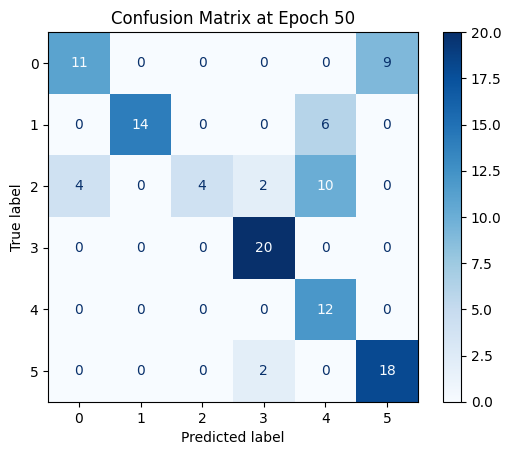

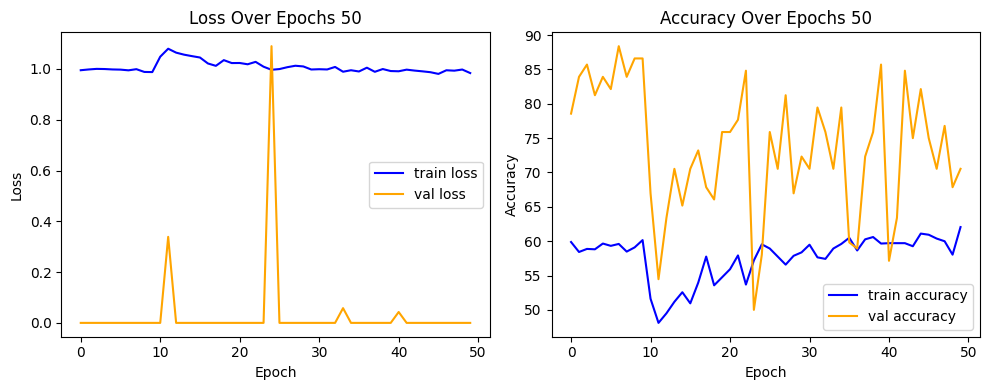

shape of y_pred:torch.Size([112, 6])
shape of y_target:torch.Size([112, 6])
SP-[1] Epoch: 51/300 | Time: 0m05s (Train 0m05s  Val 0m00s) | Train: LR 0.1  Loss 0.99  Acc 61.05% | Val: Loss nan  Acc(top1) 71.43%  HA 88.39| best sum 236.38@7


/home/sail/sound_project/sound_ai_v2_more_cnn/sys/retrain.py:190: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x)


shape of y_pred:torch.Size([112, 6])
shape of y_target:torch.Size([112, 6])
SP-[1] Epoch: 52/300 | Time: 0m05s (Train 0m05s  Val 0m00s) | Train: LR 0.1  Loss 0.99  Acc 62.33% | Val: Loss nan  Acc(top1) 52.68%  HA 88.39| best sum 236.38@7
shape of y_pred:torch.Size([112, 6])
shape of y_target:torch.Size([112, 6])
SP-[1] Epoch: 53/300 | Time: 0m05s (Train 0m05s  Val 0m00s) | Train: LR 0.1  Loss 0.98  Acc 63.67% | Val: Loss nan  Acc(top1) 85.71%  HA 88.39| best sum 236.38@7
shape of y_pred:torch.Size([112, 6])
shape of y_target:torch.Size([112, 6])
SP-[1] Epoch: 54/300 | Time: 0m05s (Train 0m05s  Val 0m00s) | Train: LR 0.1  Loss 0.98  Acc 60.94% | Val: Loss nan  Acc(top1) 61.61%  HA 88.39| best sum 236.38@7
shape of y_pred:torch.Size([112, 6])
shape of y_target:torch.Size([112, 6])
SP-[1] Epoch: 55/300 | Time: 0m05s (Train 0m05s  Val 0m00s) | Train: LR 0.1  Loss 0.97  Acc 63.78% | Val: Loss nan  Acc(top1) 77.68%  HA 88.39| best sum 236.38@7
shape of y_pred:torch.Size([112, 6])
shape of y_

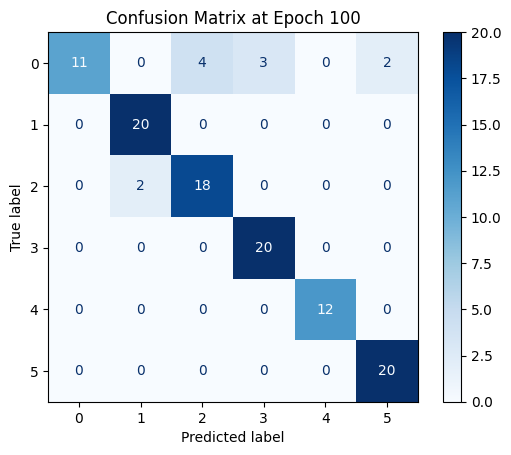

/home/uecai/.local/lib/python3.10/site-packages/matplotlib/axes/_base.py:2985: RuntimeWarning: overflow encountered in scalar add
  x0, x1 = inverse_trans.transform([x0t - delta, x1t + delta])


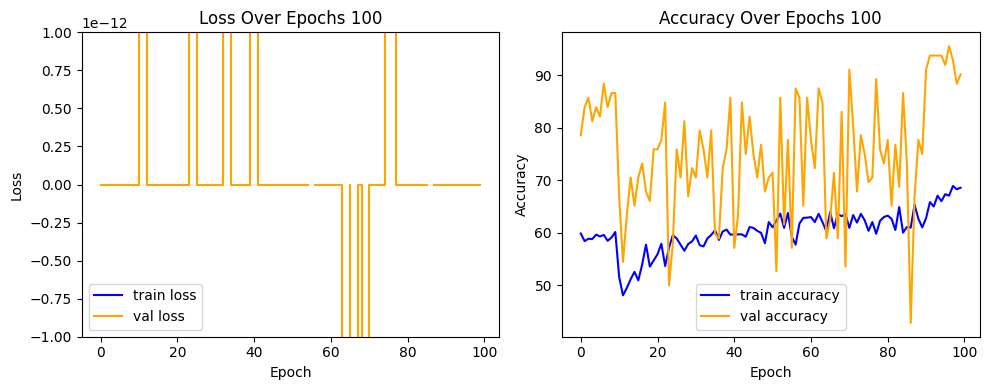

shape of y_pred:torch.Size([112, 6])
shape of y_target:torch.Size([112, 6])
SP-[1] Epoch: 101/300 | Time: 0m05s (Train 0m05s  Val 0m00s) | Train: LR 0.010000000000000002  Loss 0.95  Acc 67.47% | Val: Loss nan  Acc(top1) 93.75%  HA 95.54| best sum 258.15@97


/home/sail/sound_project/sound_ai_v2_more_cnn/sys/retrain.py:190: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x)


shape of y_pred:torch.Size([112, 6])
shape of y_target:torch.Size([112, 6])
SP-[1] Epoch: 102/300 | Time: 0m05s (Train 0m05s  Val 0m00s) | Train: LR 0.010000000000000002  Loss 0.95  Acc 65.29% | Val: Loss nan  Acc(top1) 90.18%  HA 95.54| best sum 258.15@97
shape of y_pred:torch.Size([112, 6])
shape of y_target:torch.Size([112, 6])
SP-[1] Epoch: 103/300 | Time: 0m05s (Train 0m05s  Val 0m00s) | Train: LR 0.010000000000000002  Loss 0.95  Acc 68.42% | Val: Loss nan  Acc(top1) 87.50%  HA 95.54| best sum 258.15@97
shape of y_pred:torch.Size([112, 6])
shape of y_target:torch.Size([112, 6])
SP-[1] Epoch: 104/300 | Time: 0m05s (Train 0m05s  Val 0m00s) | Train: LR 0.010000000000000002  Loss 0.94  Acc 66.52% | Val: Loss nan  Acc(top1) 90.18%  HA 95.54| best sum 258.15@97
shape of y_pred:torch.Size([112, 6])
shape of y_target:torch.Size([112, 6])
SP-[1] Epoch: 105/300 | Time: 0m05s (Train 0m05s  Val 0m00s) | Train: LR 0.010000000000000002  Loss 0.94  Acc 66.85% | Val: Loss nan  Acc(top1) 91.07%  H

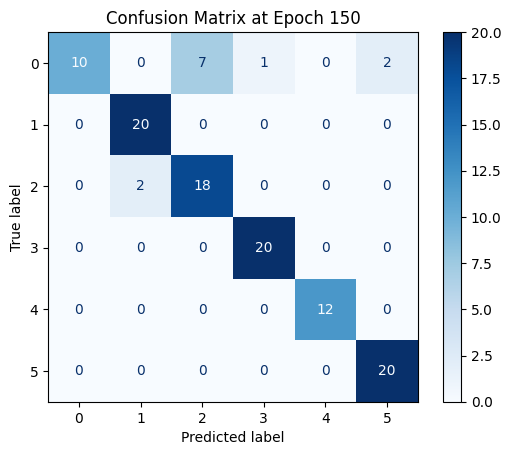

/home/uecai/.local/lib/python3.10/site-packages/matplotlib/axes/_base.py:2985: RuntimeWarning: overflow encountered in scalar add
  x0, x1 = inverse_trans.transform([x0t - delta, x1t + delta])


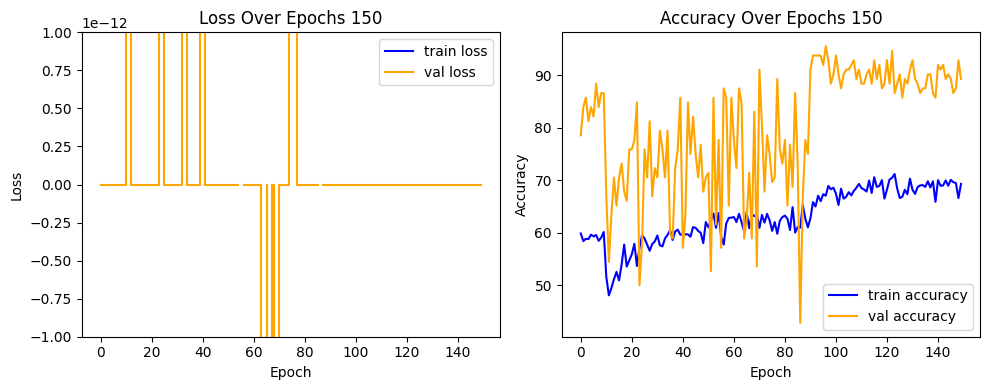

shape of y_pred:torch.Size([112, 6])
shape of y_target:torch.Size([112, 6])
SP-[1] Epoch: 151/300 | Time: 0m05s (Train 0m05s  Val 0m00s) | Train: LR 0.0010000000000000002  Loss 0.93  Acc 69.75% | Val: Loss nan  Acc(top1) 89.29%  HA 95.54| best sum 329.58@97


/home/sail/sound_project/sound_ai_v2_more_cnn/sys/retrain.py:190: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x)


shape of y_pred:torch.Size([112, 6])
shape of y_target:torch.Size([112, 6])
SP-[1] Epoch: 152/300 | Time: 0m05s (Train 0m05s  Val 0m00s) | Train: LR 0.0010000000000000002  Loss 0.93  Acc 70.81% | Val: Loss nan  Acc(top1) 89.29%  HA 95.54| best sum 329.58@97
shape of y_pred:torch.Size([112, 6])
shape of y_target:torch.Size([112, 6])
SP-[1] Epoch: 153/300 | Time: 0m05s (Train 0m05s  Val 0m00s) | Train: LR 0.0010000000000000002  Loss 0.93  Acc 69.48% | Val: Loss nan  Acc(top1) 88.39%  HA 95.54| best sum 329.58@97
shape of y_pred:torch.Size([112, 6])
shape of y_target:torch.Size([112, 6])
SP-[1] Epoch: 154/300 | Time: 0m05s (Train 0m05s  Val 0m00s) | Train: LR 0.0010000000000000002  Loss 0.93  Acc 69.81% | Val: Loss nan  Acc(top1) 88.39%  HA 95.54| best sum 329.58@97
shape of y_pred:torch.Size([112, 6])
shape of y_target:torch.Size([112, 6])
SP-[1] Epoch: 155/300 | Time: 0m05s (Train 0m05s  Val 0m00s) | Train: LR 0.0010000000000000002  Loss 0.92  Acc 69.70% | Val: Loss nan  Acc(top1) 88.39

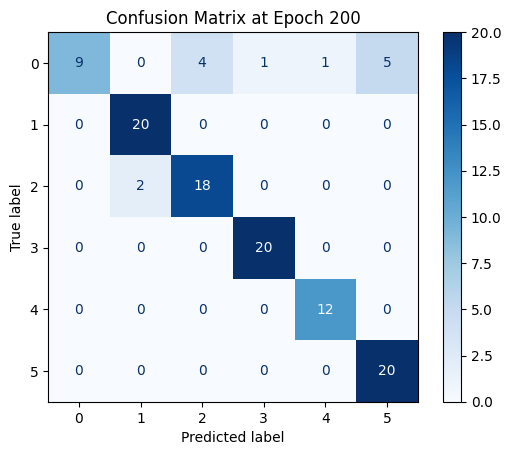

/home/uecai/.local/lib/python3.10/site-packages/matplotlib/axes/_base.py:2985: RuntimeWarning: overflow encountered in scalar add
  x0, x1 = inverse_trans.transform([x0t - delta, x1t + delta])


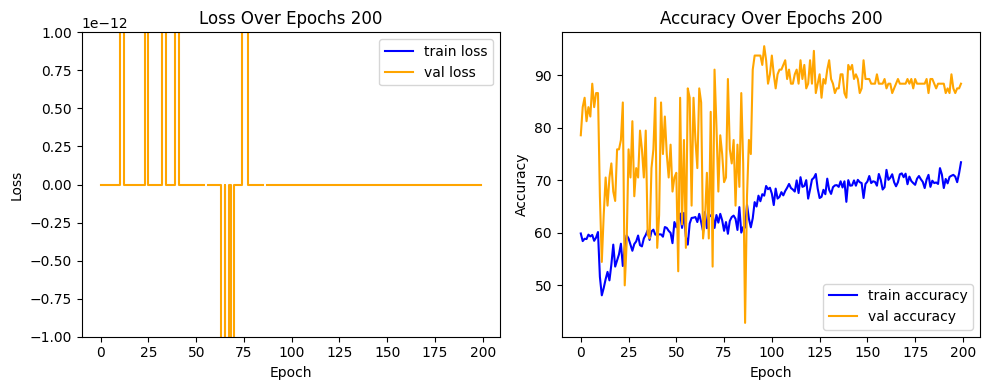

shape of y_pred:torch.Size([112, 6])
shape of y_target:torch.Size([112, 6])
SP-[1] Epoch: 201/300 | Time: 0m05s (Train 0m05s  Val 0m00s) | Train: LR 0.0010000000000000002  Loss 0.93  Acc 71.71% | Val: Loss nan  Acc(top1) 89.29%  HA 95.54| best sum 330.80@97


/home/sail/sound_project/sound_ai_v2_more_cnn/sys/retrain.py:190: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x)


shape of y_pred:torch.Size([112, 6])
shape of y_target:torch.Size([112, 6])
SP-[1] Epoch: 202/300 | Time: 0m05s (Train 0m05s  Val 0m00s) | Train: LR 0.0010000000000000002  Loss 0.92  Acc 71.76% | Val: Loss nan  Acc(top1) 87.50%  HA 95.54| best sum 330.80@97
shape of y_pred:torch.Size([112, 6])
shape of y_target:torch.Size([112, 6])
SP-[1] Epoch: 203/300 | Time: 0m05s (Train 0m05s  Val 0m00s) | Train: LR 0.0010000000000000002  Loss 0.93  Acc 69.53% | Val: Loss nan  Acc(top1) 87.50%  HA 95.54| best sum 330.80@97
shape of y_pred:torch.Size([112, 6])
shape of y_target:torch.Size([112, 6])
SP-[1] Epoch: 204/300 | Time: 0m05s (Train 0m05s  Val 0m00s) | Train: LR 0.0010000000000000002  Loss 0.91  Acc 72.60% | Val: Loss nan  Acc(top1) 88.39%  HA 95.54| best sum 330.80@97
shape of y_pred:torch.Size([112, 6])
shape of y_target:torch.Size([112, 6])
SP-[1] Epoch: 205/300 | Time: 0m05s (Train 0m05s  Val 0m00s) | Train: LR 0.0010000000000000002  Loss 0.92  Acc 71.54% | Val: Loss nan  Acc(top1) 87.50

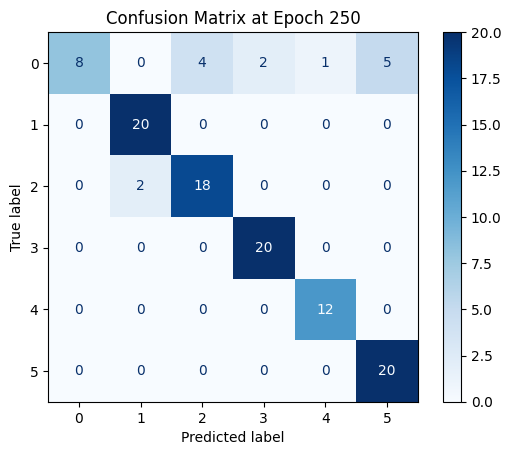

/home/uecai/.local/lib/python3.10/site-packages/matplotlib/axes/_base.py:2985: RuntimeWarning: overflow encountered in scalar add
  x0, x1 = inverse_trans.transform([x0t - delta, x1t + delta])


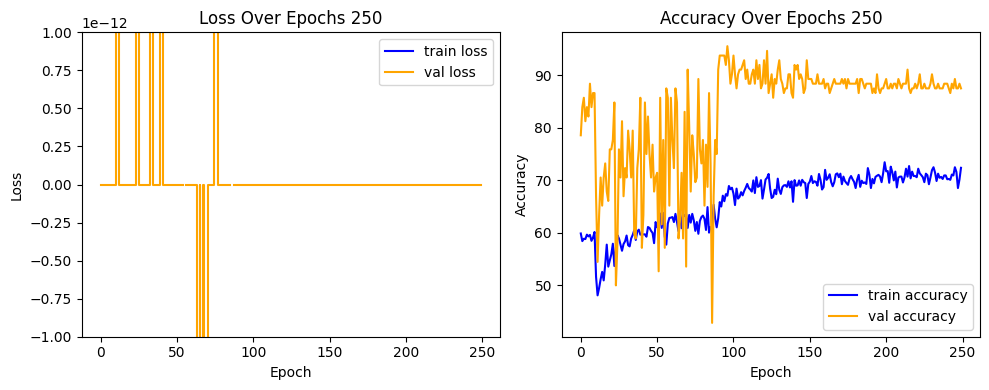

shape of y_pred:torch.Size([112, 6])
shape of y_target:torch.Size([112, 6])
SP-[1] Epoch: 251/300 | Time: 0m05s (Train 0m05s  Val 0m00s) | Train: LR 0.0010000000000000002  Loss 0.92  Acc 71.54% | Val: Loss nan  Acc(top1) 86.61%  HA 95.54| best sum 330.80@97


/home/sail/sound_project/sound_ai_v2_more_cnn/sys/retrain.py:190: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x)


shape of y_pred:torch.Size([112, 6])
shape of y_target:torch.Size([112, 6])
SP-[1] Epoch: 252/300 | Time: 0m05s (Train 0m05s  Val 0m00s) | Train: LR 0.0010000000000000002  Loss 0.93  Acc 69.48% | Val: Loss nan  Acc(top1) 87.50%  HA 95.54| best sum 330.80@97
shape of y_pred:torch.Size([112, 6])
shape of y_target:torch.Size([112, 6])
SP-[1] Epoch: 253/300 | Time: 0m05s (Train 0m05s  Val 0m00s) | Train: LR 0.0010000000000000002  Loss 0.93  Acc 69.81% | Val: Loss nan  Acc(top1) 87.50%  HA 95.54| best sum 330.80@97
shape of y_pred:torch.Size([112, 6])
shape of y_target:torch.Size([112, 6])
SP-[1] Epoch: 254/300 | Time: 0m05s (Train 0m05s  Val 0m00s) | Train: LR 0.0010000000000000002  Loss 0.93  Acc 69.59% | Val: Loss nan  Acc(top1) 87.50%  HA 95.54| best sum 330.80@97
shape of y_pred:torch.Size([112, 6])
shape of y_target:torch.Size([112, 6])
SP-[1] Epoch: 255/300 | Time: 0m05s (Train 0m05s  Val 0m00s) | Train: LR 0.0010000000000000002  Loss 0.94  Acc 70.31% | Val: Loss nan  Acc(top1) 88.39

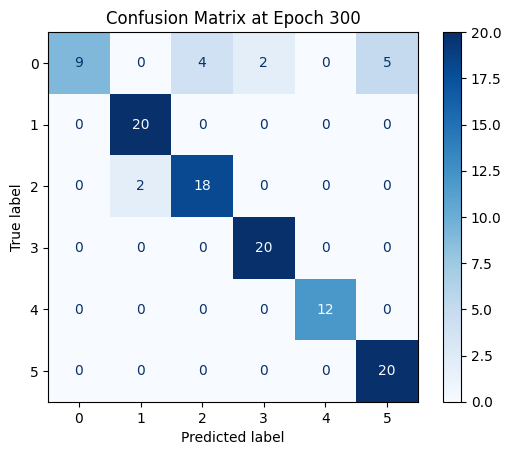

/home/uecai/.local/lib/python3.10/site-packages/matplotlib/axes/_base.py:2985: RuntimeWarning: overflow encountered in scalar add
  x0, x1 = inverse_trans.transform([x0t - delta, x1t + delta])


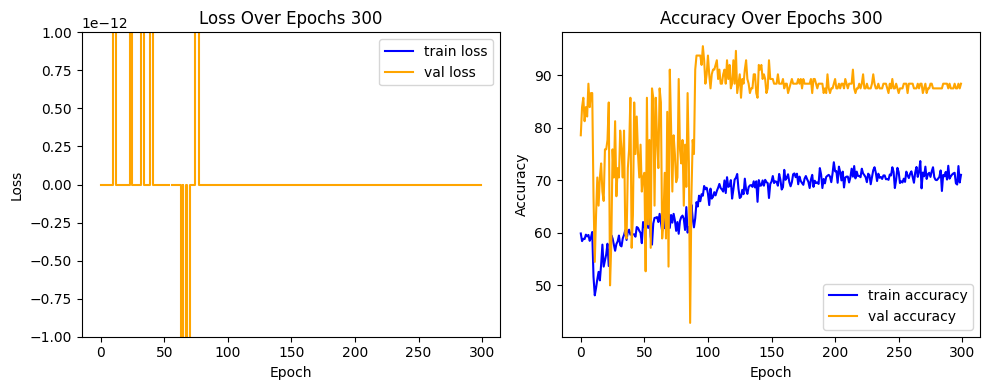

Execution finished in: 26m27s


In [31]:
step_4_model_path = main()

In [32]:
step_4_model_path

'/home/sail/sound_project/sound_ai_v2_more_cnn/sys/step_4_retrain/20241023_19/retrain_4C_after_2nd_pruning_prunratio0.9_2024102319/6C_model_cnnretrained_ratio90.0000_vaacc88.3929_tracc_73.6607@268epoch.pt'

## step5

In [33]:
step_4_model_path = '/home/sail/sound_project/sound_ai_v2_more_cnn/sys/step_4_retrain/20241023_15/retrain_4C_after_2nd_pruning_prunratio0.9_2024102315/6C_model_cnnretrained_ratio90.0000_vaacc93.7500_tracc_69.5871@119epoch.pt'

In [34]:
step_now = 'sys/step_5_conv_int8'
date_time = datetime.now().strftime("%Y%m%d_%H")  # %M
save_step_path = f'{project_PATH}/{step_now}/save_pt_model_s5'
save_pt_model_path = f'{save_step_path}/{date_time}'


In [35]:
date_time = datetime.now().strftime("%Y%m%d_%H")  # %M
save_pt_model_path = f'{project_PATH}/{step_now}/save_pt_model_s5'

save_tflite_model_path = f'{project_PATH}/{step_now}/save_tflite_model_s5'
try:
    os.mkdir(save_pt_model_path)
    print(f"Folder '{save_pt_model_path}' created successfully.")
except FileExistsError:
    print(f"Folder '{save_pt_model_path}' already exists.")

try:
    os.mkdir(save_tflite_model_path)
    print(f"Folder '{save_tflite_model_path}' created successfully.")
except FileExistsError:
    print(f"Folder '{save_tflite_model_path}' already exists.")

save_pt_model_path = f'{project_PATH}/{step_now}/save_pt_model_s5/{date_time}'

save_tflite_model_path = f'{project_PATH}/{step_now}/save_tflite_model_s5/{date_time}'
try:
    os.mkdir(save_pt_model_path)
    print(f"Folder '{save_pt_model_path}' created successfully.")
except FileExistsError:
    print(f"Folder '{save_pt_model_path}' already exists.")

try:
    os.mkdir(save_pt_model_path+'/uncompressed_qat_models')
    print(f"Folder '{save_pt_model_path}' created successfully.")
except FileExistsError:
    print(f"Folder '{save_pt_model_path}' already exists.")
    
try:
    os.mkdir(save_tflite_model_path)
    print(f"Folder '{save_tflite_model_path}' created successfully.")
except FileExistsError:
    print(f"Folder '{save_tflite_model_path}' already exists.")

Folder '/home/sail/sound_project/sound_ai_v2_more_cnn/sys/step_5_conv_int8/save_pt_model_s5' already exists.
Folder '/home/sail/sound_project/sound_ai_v2_more_cnn/sys/step_5_conv_int8/save_tflite_model_s5' already exists.
Folder '/home/sail/sound_project/sound_ai_v2_more_cnn/sys/step_5_conv_int8/save_pt_model_s5/20241023_19' created successfully.
Folder '/home/sail/sound_project/sound_ai_v2_more_cnn/sys/step_5_conv_int8/save_pt_model_s5/20241023_19' created successfully.
Folder '/home/sail/sound_project/sound_ai_v2_more_cnn/sys/step_5_conv_int8/save_tflite_model_s5/20241023_19' created successfully.


In [36]:
def display_info(opt):
    print('+------------------------------+');
    print('| {} Sound classification'.format(opt.netType));
    print('+------------------------------+');
    print('| dataset  : {}'.format(opt.dataset));
    print('| nEpochs  : {}'.format(opt.nEpochs));
    print('| LRInit   : {}'.format(opt.lr));
    print('| schedule : {}'.format(opt.schedule));
    print('| warmup   : {}'.format(opt.warmup));
    print('| batchSize: {}'.format(opt.batchSize));
    print('| nFolds: {}'.format(opt.nFolds));
    print('| Splits: {}'.format(opt.splits));
    print('| Device: {}'.format(opt.device));
    print('| Model Path: {}'.format(opt.model_path));
    print('| Model Name: {}'.format(opt.model_name));
    print('+------------------------------+');

In [37]:
from convint8 import QATTrainer

In [51]:
def main():
    opt = getOpts();#opts.parse();
    opt.device = 'cpu';
    opt.saveInfo = "uec_v2.2_sail1014"
    opt.model_path = step_4_model_path

    opt.save_tflite_model_path = save_tflite_model_path
    opt.logSaveDir = opt.save_tflite_model_path 
    opt.save_pt_model_path = save_pt_model_path
    timeStr = genDataTimeStr();
    opt.model_name = save_model_name+"qat_model_{}_{}".format(opt.saveInfo,timeStr);
   
    opt.lr = 0.01; # 0.1
    # opt.nEpochs = ; # 1600
    # opt.schedule = [0.05, 0.1, 0.3, 0.5];
    opt.schedule = [0.001, 0.003, 0.005, 0.01];
    # opt.warmup = 10;

    opt.split = 1;
    opt.hasQuated = False;
    display_info(opt);
    trainer = QATTrainer(opt);

    print('Testing performance of the provided model.....');
    trainer.TestModel();

    print('Quantization process is started.....');
    trainer.QuantizeModel();
    print('Quantization done');

    return opt.tflite_path
    # print('Testing quantized model.');
    # trainer.TestModel(True);
    # print('Finished');

***Use device:cuda:0
+------------------------------+
| add_attention Sound classification
+------------------------------+
| dataset  : v2.2.2
| nEpochs  : 300
| LRInit   : 0.01
| schedule : [0.001, 0.003, 0.005, 0.01]
| warmup   : 10
| batchSize: 64
| nFolds: 1
| Splits: [1]
| Device: cpu
| Model Path: /home/sail/sound_project/sound_ai_v2_more_cnn/sys/step_4_retrain/20241023_15/retrain_4C_after_2nd_pruning_prunratio0.9_2024102315/6C_model_cnnretrained_ratio90.0000_vaacc93.7500_tracc_69.5871@119epoch.pt
| Model Name: 6C_model_cnnqat_model_uec_v2.2_sail1014_20241024083815
+------------------------------+
random other
random other
device is: cpu
Testing performance of the provided model.....
has not quanted, load unquanted model...
[1, 1, 32, 1, 15, 11, 14, 14, 6]
self.ch_config [1, 1, 32, 1, 15, 11, 14, 14, 6]
self.tfeb Sequential(
  (0): Conv2d(1, 15, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (1): BatchNorm2d(15, eps=1e-05, momentum=0.1, affine=True, track_runni

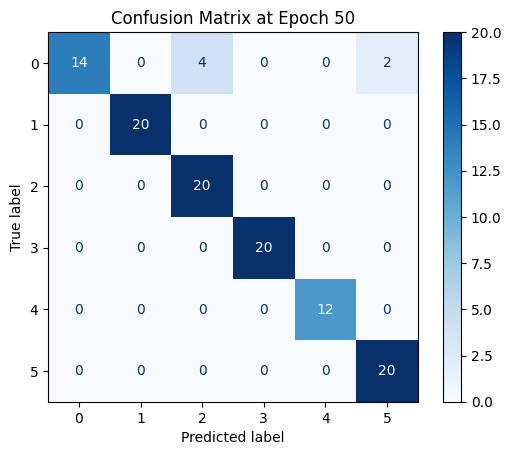

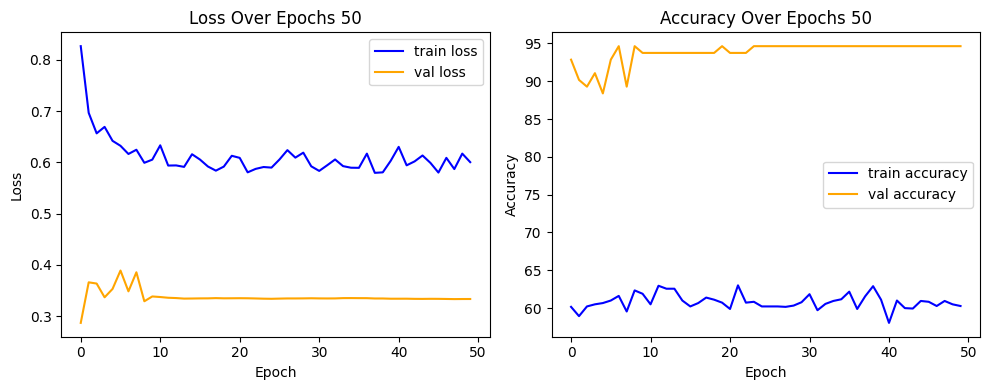

current best Acc is 94.64286041259766
pass in acc is 94.64286041259766
SP-[1] Epoch: 51/300 | Time: 0m04s (Train 0m04s  Val 0m00s) | Train: lr 1.0000000000000002e-06  Loss 0.60  Acc 61.27% | Val: Loss 0.33  Acc(top1) 94.64% | HA 94.64@7
current best Acc is 94.64286041259766
pass in acc is 94.64286041259766
SP-[1] Epoch: 52/300 | Time: 0m05s (Train 0m04s  Val 0m00s) | Train: lr 1.0000000000000002e-06  Loss 0.58  Acc 61.83% | Val: Loss 0.33  Acc(top1) 94.64% | HA 94.64@7
current best Acc is 94.64286041259766
pass in acc is 94.64286041259766
SP-[1] Epoch: 53/300 | Time: 0m04s (Train 0m04s  Val 0m00s) | Train: lr 1.0000000000000002e-06  Loss 0.59  Acc 60.94% | Val: Loss 0.33  Acc(top1) 94.64% | HA 94.64@7
current best Acc is 94.64286041259766
pass in acc is 94.64286041259766
SP-[1] Epoch: 54/300 | Time: 0m05s (Train 0m04s  Val 0m00s) | Train: lr 1.0000000000000002e-06  Loss 0.58  Acc 59.21% | Val: Loss 0.33  Acc(top1) 94.64% | HA 94.64@7
current best Acc is 94.64286041259766
pass in acc is

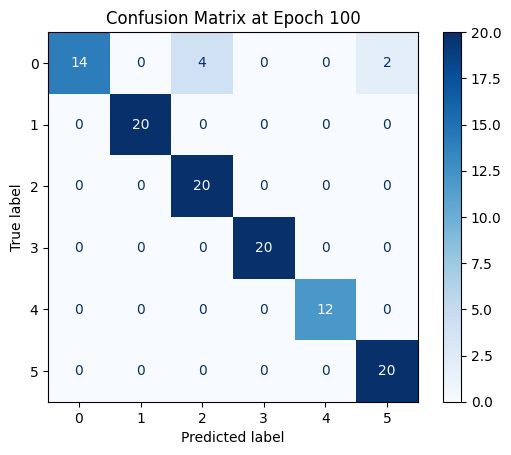

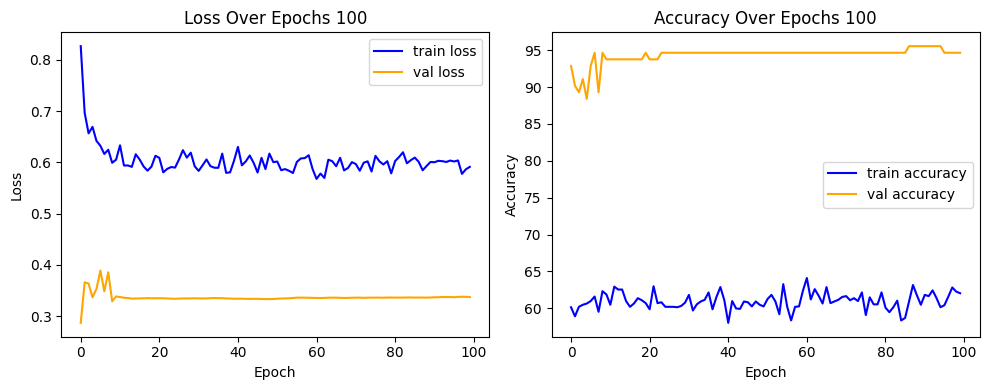

current best Acc is 95.53571319580078
pass in acc is 94.64286041259766
SP-[1] Epoch: 101/300 | Time: 0m05s (Train 0m05s  Val 0m00s) | Train: lr 1.0000000000000002e-06  Loss 0.59  Acc 60.38% | Val: Loss 0.34  Acc(top1) 94.64% | HA 95.54@87
current best Acc is 95.53571319580078
pass in acc is 94.64286041259766
SP-[1] Epoch: 102/300 | Time: 0m05s (Train 0m05s  Val 0m00s) | Train: lr 1.0000000000000002e-06  Loss 0.60  Acc 60.38% | Val: Loss 0.34  Acc(top1) 94.64% | HA 95.54@87
current best Acc is 95.53571319580078
pass in acc is 94.64286041259766
SP-[1] Epoch: 103/300 | Time: 0m05s (Train 0m04s  Val 0m00s) | Train: lr 1.0000000000000002e-06  Loss 0.59  Acc 61.89% | Val: Loss 0.34  Acc(top1) 94.64% | HA 95.54@87
current best Acc is 95.53571319580078
pass in acc is 94.64286041259766
SP-[1] Epoch: 104/300 | Time: 0m05s (Train 0m05s  Val 0m00s) | Train: lr 1.0000000000000002e-06  Loss 0.59  Acc 62.00% | Val: Loss 0.34  Acc(top1) 94.64% | HA 95.54@87
current best Acc is 95.53571319580078
pass i

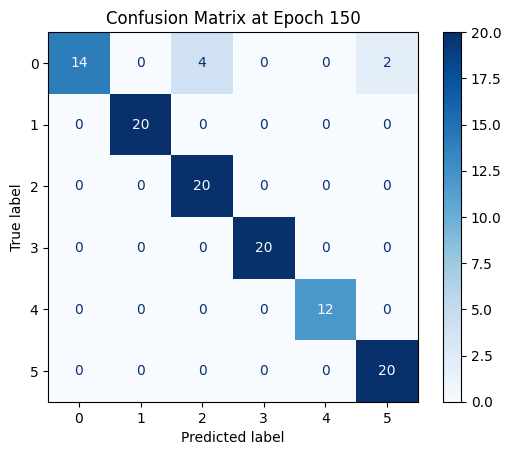

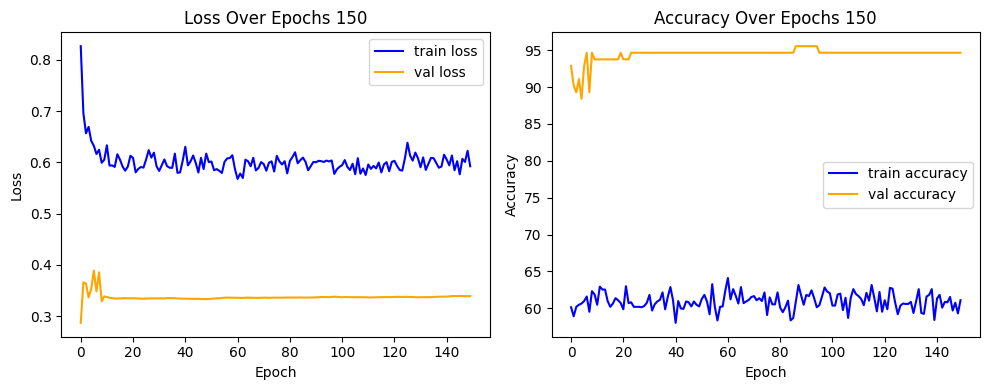

current best Acc is 95.53571319580078
pass in acc is 94.64286041259766
SP-[1] Epoch: 151/300 | Time: 0m05s (Train 0m05s  Val 0m00s) | Train: lr 1.0000000000000002e-06  Loss 0.59  Acc 59.82% | Val: Loss 0.34  Acc(top1) 94.64% | HA 95.54@87
current best Acc is 95.53571319580078
pass in acc is 94.64286041259766
SP-[1] Epoch: 152/300 | Time: 0m05s (Train 0m05s  Val 0m00s) | Train: lr 1.0000000000000002e-06  Loss 0.61  Acc 61.66% | Val: Loss 0.34  Acc(top1) 94.64% | HA 95.54@87
current best Acc is 95.53571319580078
pass in acc is 94.64286041259766
SP-[1] Epoch: 153/300 | Time: 0m05s (Train 0m04s  Val 0m00s) | Train: lr 1.0000000000000002e-06  Loss 0.60  Acc 60.32% | Val: Loss 0.34  Acc(top1) 94.64% | HA 95.54@87
current best Acc is 95.53571319580078
pass in acc is 94.64286041259766
SP-[1] Epoch: 154/300 | Time: 0m05s (Train 0m05s  Val 0m00s) | Train: lr 1.0000000000000002e-06  Loss 0.59  Acc 60.94% | Val: Loss 0.34  Acc(top1) 94.64% | HA 95.54@87
current best Acc is 95.53571319580078
pass i

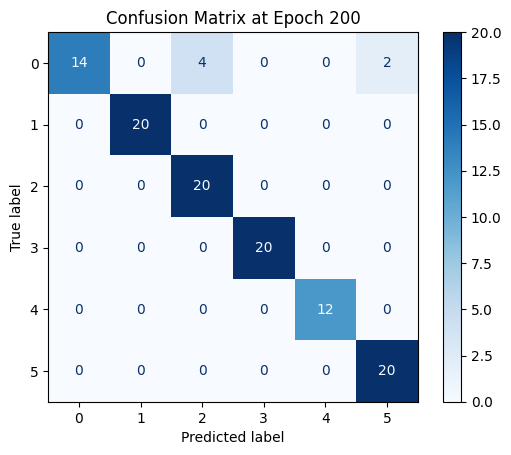

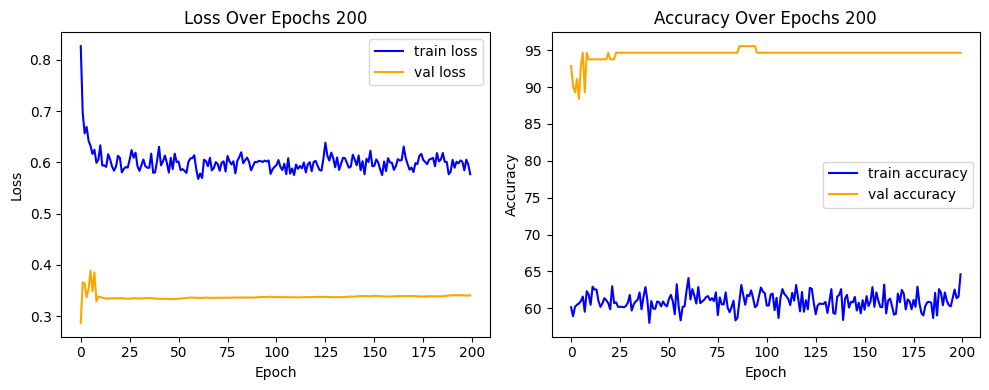

current best Acc is 95.53571319580078
pass in acc is 94.64286041259766
SP-[1] Epoch: 201/300 | Time: 0m05s (Train 0m05s  Val 0m00s) | Train: lr 1.0000000000000002e-06  Loss 0.58  Acc 63.06% | Val: Loss 0.34  Acc(top1) 94.64% | HA 95.54@87
current best Acc is 95.53571319580078
pass in acc is 94.64286041259766
SP-[1] Epoch: 202/300 | Time: 0m05s (Train 0m05s  Val 0m00s) | Train: lr 1.0000000000000002e-06  Loss 0.60  Acc 61.55% | Val: Loss 0.34  Acc(top1) 94.64% | HA 95.54@87
current best Acc is 95.53571319580078
pass in acc is 94.64286041259766
SP-[1] Epoch: 203/300 | Time: 0m05s (Train 0m05s  Val 0m00s) | Train: lr 1.0000000000000002e-06  Loss 0.59  Acc 61.16% | Val: Loss 0.34  Acc(top1) 94.64% | HA 95.54@87
current best Acc is 95.53571319580078
pass in acc is 94.64286041259766
SP-[1] Epoch: 204/300 | Time: 0m05s (Train 0m04s  Val 0m00s) | Train: lr 1.0000000000000002e-06  Loss 0.58  Acc 61.38% | Val: Loss 0.34  Acc(top1) 94.64% | HA 95.54@87
current best Acc is 95.53571319580078
pass i

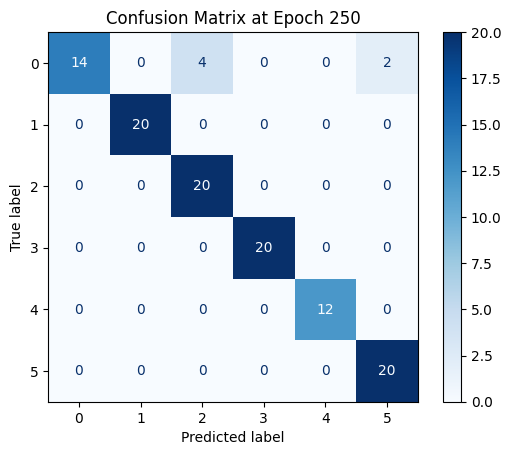

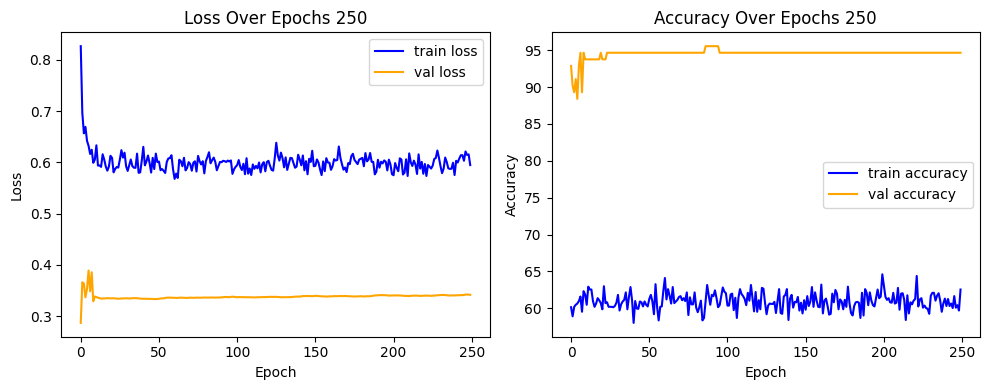

current best Acc is 95.53571319580078
pass in acc is 94.64286041259766
SP-[1] Epoch: 251/300 | Time: 0m05s (Train 0m04s  Val 0m00s) | Train: lr 1.0000000000000002e-06  Loss 0.60  Acc 60.77% | Val: Loss 0.34  Acc(top1) 94.64% | HA 95.54@87
current best Acc is 95.53571319580078
pass in acc is 94.64286041259766
SP-[1] Epoch: 252/300 | Time: 0m05s (Train 0m05s  Val 0m00s) | Train: lr 1.0000000000000002e-06  Loss 0.62  Acc 58.09% | Val: Loss 0.34  Acc(top1) 94.64% | HA 95.54@87
current best Acc is 95.53571319580078
pass in acc is 94.64286041259766
SP-[1] Epoch: 253/300 | Time: 0m05s (Train 0m05s  Val 0m00s) | Train: lr 1.0000000000000002e-06  Loss 0.62  Acc 58.43% | Val: Loss 0.34  Acc(top1) 94.64% | HA 95.54@87
current best Acc is 95.53571319580078
pass in acc is 94.64286041259766
SP-[1] Epoch: 254/300 | Time: 0m05s (Train 0m05s  Val 0m00s) | Train: lr 1.0000000000000002e-06  Loss 0.60  Acc 60.99% | Val: Loss 0.34  Acc(top1) 94.64% | HA 95.54@87
current best Acc is 95.53571319580078
pass i

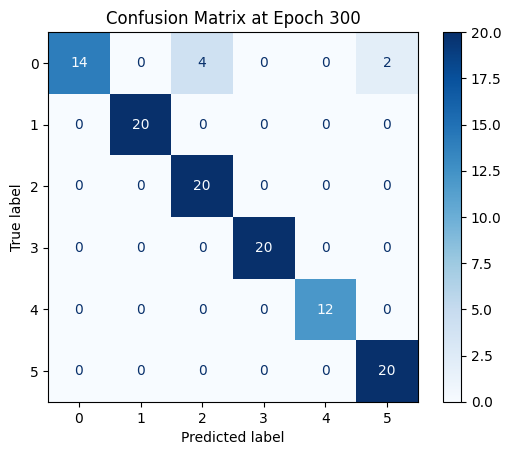

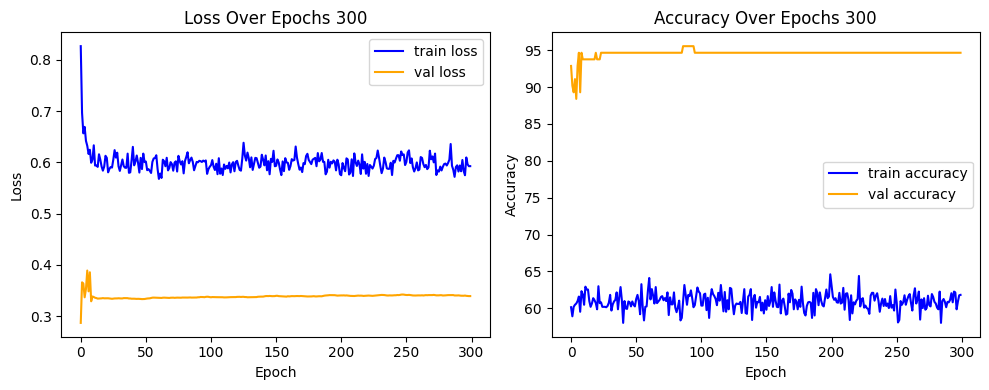

Execution finished in: 25m21s
Post Training Quantization: Convert done
Size of model after quantization
Size (MB): 0.010606
device is: cpu
torch.Size([112, 6])
Testing: Acc(top1) 85.71%


INFO (tinynn.converter.base) Generated model saved to /home/sail/sound_project/sound_ai_v2_more_cnn/sys/step_5_conv_int8/save_tflite_model_s5/20241023_19/6C_model_cnnqat_model_uec_v2.2_sail1014_20241024083815.tflite


Quantization done


In [52]:
tflite_path = main()

## check

In [40]:
tflite_path

'/home/sail/sound_project/sound_ai_v2_more_cnn/sys/step_5_conv_int8/save_tflite_model_s5/20241023_19/6C_model_cnnqat_model_uec_v2.2_sail1014_20241023195349.tflite'

In [41]:
import tensorflow as tf


interpreter = tf.lite.Interpreter(model_path=tflite_path)

interpreter.allocate_tensors()

# 獲取張量細節
tensor_details = interpreter.get_tensor_details()

# 檢查每個張量的類型
for tensor in tensor_details:
    tensor_name = tensor['name']
    tensor_type = tensor['dtype']
    print(f"Tensor: {tensor_name}, Type: {tensor_type}")

# 檢查輸入和輸出張量的類型
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("\nInput Tensors:")
for input_tensor in input_details:
    print(f"Name: {input_tensor['name']}, Type: {input_tensor['dtype']}")

print("\nOutput Tensors:")
for output_tensor in output_details:
    print(f"Name: {output_tensor['name']}, Type: {output_tensor['dtype']}")


2024-10-23 20:19:49.549891: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-23 20:19:49.557277: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-23 20:19:49.564653: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-23 20:19:49.566772: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-23 20:19:49.572861: I tensorflow/core/platform/cpu_feature_guar

Tensor: input.1_transform_1, Type: <class 'numpy.int8'>
Tensor: input.2_te_transform, Type: <class 'numpy.int8'>
Tensor: input.10_te_transform, Type: <class 'numpy.int8'>
Tensor: input.8_transform, Type: <class 'numpy.int8'>
Tensor: input.10_attr_1, Type: <class 'numpy.int32'>
Tensor: input.1_transform, Type: <class 'numpy.int8'>
Tensor: fuse_attr_5, Type: <class 'numpy.int8'>
Tensor: Xq.1_attr, Type: <class 'numpy.int8'>
Tensor: x.1_transform_1, Type: <class 'numpy.int8'>
Tensor: input.6_attr_1, Type: <class 'numpy.int32'>
Tensor: 112, Type: <class 'numpy.int8'>
Tensor: x.1_transform, Type: <class 'numpy.int8'>
Tensor: input.4_transform, Type: <class 'numpy.int8'>
Tensor: input.2_attr_1, Type: <class 'numpy.int32'>
Tensor: Xq.1, Type: <class 'numpy.int8'>
Tensor: fuse_attr_7, Type: <class 'numpy.int8'>
Tensor: fuse_attr_2, Type: <class 'numpy.int32'>
Tensor: fuse_attr_6, Type: <class 'numpy.int8'>
Tensor: fuse_attr_3, Type: <class 'numpy.int8'>
Tensor: input.10_te_transform_1_te_trans

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [42]:
tensor_details

[{'name': 'input.1_transform_1',
  'index': 0,
  'shape': array([ 1,  1,  1, 14], dtype=int32),
  'shape_signature': array([ 1,  1,  1, 14], dtype=int32),
  'dtype': numpy.int8,
  'quantization': (11.122087478637695, -128),
  'quantization_parameters': {'scales': array([11.1220875], dtype=float32),
   'zero_points': array([-128], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}},
 {'name': 'input.2_te_transform',
  'index': 1,
  'shape': array([    1,     1, 16000,     1], dtype=int32),
  'shape_signature': array([    1,     1, 16000,     1], dtype=int32),
  'dtype': numpy.int8,
  'quantization': (0.022231027483940125, 1),
  'quantization_parameters': {'scales': array([0.02223103], dtype=float32),
   'zero_points': array([1], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}},
 {'name': 'input.10_te_transform',
  'index': 2,
  'shape': array([ 1,  3, 11, 11], dtype=int32),
  'shape_signature': array([ 1,  3, 11, 11], dtype=int32),
  'dtype':

# 

In [43]:
tflite_ = tflite_path
tflite_.split('/')[0]

''

In [44]:
save_name = 'model_6C_v2_cnn_10223_pr09_byChristine.cc'

In [45]:
c_ = f"/{tflite_.split('/')[1]}/{tflite_.split('/')[2]}/{tflite_.split('/')[3]}/{tflite_.split('/')[4]}/{tflite_.split('/')[5]}/{tflite_.split('/')[6]}/{tflite_.split('/')[7]}/{tflite_.split('/')[8]}/{save_name}"#tflite_[:-7]+'.cc'

! xxd -i {tflite_} > {c_}
REPLACE_TEST = "model_6c_1023_bysail";
!sed -i 's/'{REPLACE_TEST}'/g_model/g' {c_}

In [46]:
import tensorflow as tf
import numpy as np

def calculate_arena_size(tflite_model_path):
    """
    計算 TFLite 模型的內存需求（Arena size）。

    :param tflite_model_path: .tflite 模型文件的路徑
    :return: 估算的總內存需求（MB）
    """
    # 加載 TFLite 模型
    interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
    interpreter.allocate_tensors()

    # 獲取所有張量的詳細信息
    tensor_details = interpreter.get_tensor_details()

    # 計算參數內存
    total_params = 0
    params_memory = 0
    activations_memory = 0

    for tensor in tensor_details:
        name = tensor['name'].lower()
        shape = tensor['shape']
        dtype = tensor['dtype']

        # 根據數據類型確定每個元素的字節數
        if dtype == np.float32:
            bytes_per_element = 4
        elif dtype == np.int8:
            bytes_per_element = 1
        elif dtype == np.int16:
            bytes_per_element = 2
        elif dtype == np.uint8:
            bytes_per_element = 1
        else:
            bytes_per_element = 4  # 默認為 float32

        tensor_size_mb = (np.prod(shape) * bytes_per_element) / (1024 ** 2)  # 轉換為 MB

        # 假設 'weight' 和 'bias' 為參數，其他為激活
        if 'weight' in name or 'bias' in name:
            total_params += np.prod(shape)
            params_memory += (np.prod(shape) * bytes_per_element) / (1024 ** 2)  # MB
        else:
            activations_memory += tensor_size_mb  # MB

    # 臨時內存估算（假設激活內存的 20% 為臨時內存）
    temporary_memory = activations_memory * 0.2

    # 總內存需求
    total_memory = params_memory + activations_memory + temporary_memory

    print(f"dtype：{dtype} ")
    print(f"參數內存需求：{params_memory:.2f} MB")
    print(f"激活內存需求：{activations_memory:.2f} MB")
    print(f"臨時內存需求（估算）：{temporary_memory:.2f} MB")
    print(f"總內存需求（估算的 Arena size）：{total_memory:.2f} MB")

    return total_memory

# 使用範例
tflite_model = tflite_path
arena_size = calculate_arena_size(tflite_model)

dtype：<class 'numpy.int8'> 
參數內存需求：0.00 MB
激活內存需求：0.21 MB
臨時內存需求（估算）：0.04 MB
總內存需求（估算的 Arena size）：0.25 MB


In [47]:
# import tensorflow as tf


# interpreter = tf.lite.Interpreter(model_path='/hd/Rick/desktop/Works/Projects/TransferLearning_for_ACDNet/Finall_Models_Save/Alarm_Detection/Pruning_Ratio_0.6_0.85_20240221/qat_model_0.6_0.85_ratio_qatacc_95.4_20240221181601_total_epochs_200.tflite')

# interpreter.allocate_tensors()

# # 獲取張量細節
# tensor_details = interpreter.get_tensor_details()

# # 檢查每個張量的類型
# for tensor in tensor_details:
#     tensor_name = tensor['name']
#     tensor_type = tensor['dtype']
#     print(f"Tensor: {tensor_name}, Type: {tensor_type}")

# # 檢查輸入和輸出張量的類型
# input_details = interpreter.get_input_details()
# output_details = interpreter.get_output_details()

# print("\nInput Tensors:")
# for input_tensor in input_details:
#     print(f"Name: {input_tensor['name']}, Type: {input_tensor['dtype']}")

# print("\nOutput Tensors:")
# for output_tensor in output_details:
#     print(f"Name: {output_tensor['name']}, Type: {output_tensor['dtype']}")


In [48]:
# tensor_details

In [49]:
# import re

# # 假設模型數據存儲在名為 model.cc 的文件中
# input_file = '/home/sail/sound_project/sound_ai_v2/sys/step_5_conv_int8/save_tflite_model_s5/20241015_09/model_6C_v222_1015_pr09_byChristine.cc'
# output_file = 'model.tflite'

# # 讀取 C 文件
# with open(input_file, 'r') as f:
#     data = f.read()

# # 正則表達式匹配模型數據陣列
# match = re.search(r'unsigned char [^;]+', data, re.DOTALL)
# if not match:
#     raise ValueError("未找到模型數據陣列。請檢查文件內容。")

# # 提取十六進制數據
# hex_data = match.group(0)
# hex_values = re.findall(r'0x([0-9A-Fa-f]{2})', hex_data)

# # 將十六進制轉換為二進制
# binary_data = bytes(int(h, 16) for h in hex_values)

# # 保存為 .tflite 文件
# with open(output_file, 'wb') as f:
#     f.write(binary_data)



In [50]:
# import tensorflow as tf


# interpreter = tf.lite.Interpreter(model_path=output_file)

# interpreter.allocate_tensors()

# # 獲取張量細節
# tensor_details = interpreter.get_tensor_details()

# # 檢查每個張量的類型
# for tensor in tensor_details:
#     tensor_name = tensor['name']
#     tensor_type = tensor['dtype']
#     print(f"Tensor: {tensor_name}, Type: {tensor_type}")

# # 檢查輸入和輸出張量的類型
# input_details = interpreter.get_input_details()
# output_details = interpreter.get_output_details()

# print("\nInput Tensors:")
# for input_tensor in input_details:
#     print(f"Name: {input_tensor['name']}, Type: {input_tensor['dtype']}")

# print("\nOutput Tensors:")
# for output_tensor in output_details:
#     print(f"Name: {output_tensor['name']}, Type: {output_tensor['dtype']}")
